# Summary:
This notebook will cover performing **Latent Semantic Analysis (LSA)** using package from gensim to embed abstract/bodytext with title/abstract/bodytext from the same paper as validation.

# Table of contents
* [1. preprocess text file](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 method1 -- WordNetLemmatizer](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 method2 -- ScispaCy](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 compare wordcount](#Part1.3_link)
* [2. Gensim dictionary, tfidf and LSA](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Abstract + preprocess method1](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 num_topics=10](#Part2.1.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 num_topics=20](#Part2.1.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 num_topics=30](#Part2.1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 num_topics=40](#Part2.1.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.5 num_topics=50](#Part2.1.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.6 num_topics=100](#Part2.1.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Body_text + preprocess method1](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 num_topics=10](#Part2.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 num_topics=20](#Part2.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 num_topics=30](#Part2.2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.4 num_topics=40](#Part2.2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.5 num_topics=50](#Part2.2.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.6 num_topics=100](#Part2.2.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Abstract + preprocess method2 (spaCy)](#Part2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 num_topics=10](#Part2.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 num_topics=20](#Part2.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 num_topics=30](#Part2.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.4 num_topics=40](#Part2.3.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.5 num_topics=50](#Part2.3.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.6 num_topics=100](#Part2.3.6_link)
<br >&nbsp;&nbsp;&nbsp;[2.4 Body_text + preprocess method2 (spaCy)](#Part2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 num_topics=10](#Part2.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2 num_topics=20](#Part2.4.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.3 num_topics=30](#Part2.4.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.4 num_topics=40](#Part2.4.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.5 num_topics=50](#Part2.4.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.6 num_topics=100](#Part2.4.6_link)
* [3. Evaluate LSA models](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Distribution of number of papers in each topic](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Evaluate the topic prediction performance of LSA models](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Compute cosine similarity for titles, abstracts and bodytext of each paper](#Part3.3_link)
<br >&nbsp;&nbsp;&nbsp;[3.4 Evaluate cosine similarity](#Part3.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import json
import glob
from ast import literal_eval
from tqdm import tqdm

import gensim
import nltk
from nltk.stem import WordNetLemmatizer

import spacy
import scispacy
import en_core_sci_lg

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import cohen_kappa_score
import joblib
import glob

In [2]:
base_dir="/Volumes/Yuchen_Drive/COVID19/CORD19"

In [3]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21423_text_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    parse_dates=["publish_time"],usecols=["title","abstract","body_text","pubmed_id","publish_time","journal","paper_id"])


In [4]:
print(data_df.shape)
data_df.head()

(21423, 6)


,title,abstract,body_text,pubmed_id,publish_time,journal
paper_id,,,,,,
00142f93c18b07350be89e96372d240372437ed9,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,26528289,2015-10-13,Front Immunol
0022796bb2112abd2e6423ba2d57751db06049fb,Public Health Responses to and Challenges for ...,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,27643596,2016-09-19,PLoS Negl Trop Dis
0031e47b76374e05a18c266bd1a1140e5eacb54f,The fecal microbiota of healthy donor horses a...,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...,32155205,2020-03-10,PLoS One
00326efcca0852dc6e39dc6b7786267e1bc4f194,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,26925393,2016-02-18,Front Pediatr
00352a58c8766861effed18a4b079d1683fec2ec,MINI REVIEW Function of the Deubiquitinating E...,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...,29302259,2017-12-14,Front Synaptic Neurosci


<a id='Part1_link'></a>
## 1. preprocess text file

In [5]:
abstract2_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract2_TF_pre_df.csv"),index_col="token_id")
abstract2_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract2_DF_df.csv"),index_col="token_id")
abstract3_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract3_TF_pre_df.csv"),index_col="token_id")
abstract3_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_abstract3_DF_df.csv"),index_col="token_id")

bodytext2_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_TF_pre_df.csv"),index_col="token_id")
bodytext2_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext2_DF_df.csv"),index_col="token_id")
bodytext3_TF_pre=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext3_TF_pre_df.csv"),index_col="token_id")
bodytext3_DF=pd.read_csv(os.path.join(base_dir,"models_lda/word_counts/COVD19_meta_21600_text_df_bodytext3_DF_df.csv"),index_col="token_id")

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
list0 = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 
    'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', '-PRON-'
]

In [7]:
list1=list(abstract2_TF_pre.loc[abstract2_TF_pre.counts>10000].word.values)
list2=list(abstract2_DF.loc[abstract2_DF.counts>6000].word.values)
list3=list(abstract3_TF_pre.loc[abstract3_TF_pre.counts>9000].word.values)
list4=list(abstract3_DF.loc[abstract3_DF.counts>5000].word.values)
list5=list(bodytext2_TF_pre.loc[bodytext2_TF_pre.counts>100000].word.values)
list6=list(bodytext2_DF.loc[bodytext2_DF.counts>15000].word.values)
list7=list(bodytext3_TF_pre.word.values[:20])
list8=list(bodytext3_DF.loc[bodytext3_DF.counts>15000].word.values)
custom_words=set(list0+list1+list2+list3+list4+list5+list6+list7+list8)
print("Number of custom words: {}".format(len(custom_words)))

Number of custom words: 104


In [8]:
custom_words=[i.lower() for i in custom_words]

<a id='Part1.1_link'></a>
### 1.1 method1 -- WordNetLemmatizer

In [9]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
#stop_words = set(list(stop_word1)+stop_word2+list(punctuation))   ## 390+32=422
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
stop_words = set(list(stop_word1)+stop_word2+list(punct)+list(custom_words))
print(len(stop_words))

546


In [10]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

In [11]:
data_df["abstract2"]=data_df.abstract.apply(lambda x:preprocess(x))
data_df["body_text2"]=data_df.body_text.apply(lambda x:preprocess(x))
data_df["title2"]=data_df.title.apply(lambda x:preprocess(x))

<a id='Part1.2_link'></a>
### 1.2 method2 -- ScispaCy

In [137]:
nlp = spacy.load("en_core_sci_lg",disable=["tagger","parser","ner"])

In [139]:
nlp.max_length=2000000

In [140]:
for token in stop_words:
    nlp.vocab[token].is_stop=True

In [141]:
def spacy_tokenizer(text):
    words=[token.lemma_.lower() for token in nlp(text) if not (token.like_num or token.is_stop or token.is_punct or token.is_space or len(token)==1)]
    return [token for token in words if token not in stop_words]

In [142]:
data_df["abstract3"]=data_df.abstract.apply(lambda x:spacy_tokenizer(x))
data_df["body_text3"]=data_df.body_text.apply(lambda x:spacy_tokenizer(x))
data_df["title3"]=data_df.title.apply(lambda x:spacy_tokenizer(x))


<a id='Part1.3_link'></a>
### 1.3 compare wordcount

In [143]:
data_df["abstract2_wordcount"]=data_df.abstract2.apply(lambda x:len(x))
data_df["bodytext2_wordcount"]=data_df.body_text2.apply(lambda x:len(x))
data_df["title2_wordcount"]=data_df.title2.apply(lambda x:len(x))
data_df["abstract3_wordcount"]=data_df.abstract3.apply(lambda x:len(x))
data_df["bodytext3_wordcount"]=data_df.body_text3.apply(lambda x:len(x))
data_df["title3_wordcount"]=data_df.title3.apply(lambda x:len(x))

Text(0, 0.5, 'Density')

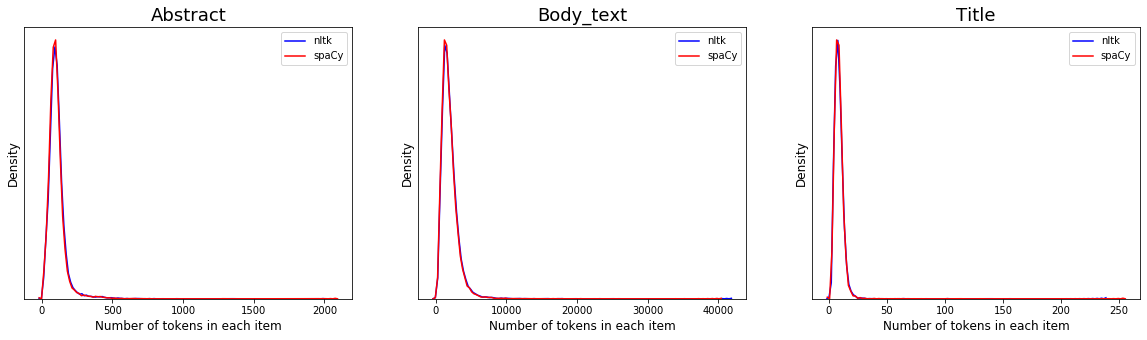

In [144]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
sns.distplot(data_df.abstract2_wordcount,color="blue",ax=axes[0],hist=False,label="nltk")
sns.distplot(data_df.abstract3_wordcount,color="red",ax=axes[0],hist=False,label="spaCy")
sns.distplot(data_df.bodytext2_wordcount,color="blue",ax=axes[1],hist=False,label="nltk")
sns.distplot(data_df.bodytext3_wordcount,color="red",ax=axes[1],hist=False,label="spaCy")
sns.distplot(data_df.title2_wordcount,color="blue",ax=axes[2],hist=False,label="nltk")
sns.distplot(data_df.title3_wordcount,color="red",ax=axes[2],hist=False,label="spaCy")

axes[0].set_title("Abstract",fontsize=18)
axes[0].set_xlabel("Number of tokens in each item",fontsize=12)
axes[0].set_yticks([])
axes[0].set_ylabel("Density",fontsize=12)

axes[1].set_title("Body_text",fontsize=18)
axes[1].set_xlabel("Number of tokens in each item",fontsize=12)
axes[1].set_yticks([])
axes[1].set_ylabel("Density",fontsize=12)

axes[2].set_title("Title",fontsize=18)
axes[2].set_xlabel("Number of tokens in each item",fontsize=12)
axes[2].set_yticks([])
axes[2].set_ylabel("Density",fontsize=12)

In [145]:
data_df.loc[:,["abstract2_wordcount","bodytext2_wordcount","title2_wordcount","abstract3_wordcount","bodytext3_wordcount","title3_wordcount"]].describe()


,abstract2_wordcount,bodytext2_wordcount,title2_wordcount,abstract3_wordcount,bodytext3_wordcount,title3_wordcount
count,21423.000000,21423.000000,21423.000000,21423.000000,21423.000000,21423.000000
mean,107.929095,1991.815245,8.582318,104.576903,1940.511693,8.590674
std,69.664103,1336.398555,5.010793,68.938066,1305.031507,4.971873
min,0.000000,9.000000,0.000000,0.000000,10.000000,0.000000
25%,73.000000,1216.000000,6.000000,70.000000,1182.000000,6.000000
50%,99.000000,1744.000000,8.000000,96.000000,1695.000000,8.000000
75%,128.000000,2458.000000,11.000000,124.000000,2399.000000,10.000000
max,1988.000000,41475.000000,237.000000,2075.000000,40040.000000,254.000000


In [ ]:
data_df.to_csv(os.path.join(base_dir,"COVD19_meta_21423_text_all_df.csv"),index=True)

<a id='Part2_link'></a>
## 2. Gensim dictionary, tfidf and LSA

In [22]:
def print_cfs_top(bow_dict,top_n):
    top={i:freq for i,freq in sorted(bow_dict.cfs.items(),key=lambda x:x[1],reverse=True)[:top_n]}
    print("Words with the highest term frequency:")
    for id,count in top.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [23]:
def print_cfs_bottom(bow_dict,bottom_n):
    bottom={i:freq for i,freq in sorted(bow_dict.cfs.items(),key=lambda x:x[1])[:bottom_n]}
    print("Words with the least term frequency:")
    for id,count in bottom.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [24]:
def generate_TF_df(bow_dict):
    word_dict={}
    count_dict={}
    for i in range(len(bow_dict)):
        word_dict[i]=bow_dict[i]
        count_dict[i]=bow_dict.cfs[i]
    df1=pd.DataFrame.from_dict(word_dict,orient="index",columns=["word"])
    df2=pd.DataFrame.from_dict(count_dict,orient="index",columns=["counts"])
    output=pd.concat([df1,df2],axis=1,sort=False)
    output.sort_values(by=["counts"],ascending=False,inplace=True)
    return output

In [25]:
def print_dfs_top(bow_dict,top_n):
    top={i:freq for i,freq in sorted(bow_dict.dfs.items(),key=lambda x:x[1],reverse=True)[:top_n]}
    print("Words with the highest document frequency:")
    for id,count in top.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [26]:
def print_dfs_bottom(bow_dict,bottom_n):
    bottom={i:freq for i,freq in sorted(bow_dict.cfs.items(),key=lambda x:x[1])[:bottom_n]}
    print("Words with the least document frequency:")
    for id,count in bottom.items():
        print("id: {}, word: {}, count: {}".format(id,bow_dict[id],count))

In [27]:
def generate_DF_df(bow_dict):
    word_dict={}
    count_dict={}
    for i in range(len(bow_dict)):
        word_dict[i]=bow_dict[i]
        count_dict[i]=bow_dict.dfs[i]
    df1=pd.DataFrame.from_dict(word_dict,orient="index",columns=["word"])
    df2=pd.DataFrame.from_dict(count_dict,orient="index",columns=["counts"])
    output=pd.concat([df1,df2],axis=1,sort=False)
    output.sort_values(by=["counts"],ascending=False,inplace=True)
    return output

In [28]:
## print_topics_method2
def print_top_words_lsa_gensim(lsa,bow_dict,n_top_words,print_message=True):
    topic_term_matrix=lsa.get_topics()
    num_topics=topic_term_matrix.shape[0]
    topic_term_df=pd.DataFrame(topic_term_matrix,columns=list(bow_dict.values()),index=np.array(["topic"+str(i) for i in range(num_topics)]))
    words_dict={}
    scores_dict={}
    topics_dict={}
    for i in range(num_topics):
        indices=topic_term_df.iloc[i,:].values.argsort()[-n_top_words:][::-1]
        words=topic_term_df.columns[indices].values
        scores=topic_term_df.iloc[i,indices].values
        words_dict["topic"+str(i)]=words
        scores_dict["topic"+str(i)]=scores
        topics_dict["topic"+str(i)]=OrderedDict([(words[i],scores[i]) for i in range(n_top_words)])
        if print_message:
            message="Topic"+str(i)+": "+" ".join(words)
            print(message)
    words_df=pd.DataFrame.from_dict(words_dict)
    scores_df=pd.DataFrame.from_dict(scores_dict)
    topics_df=pd.DataFrame(topics_dict)
    topics_df=topics_df.fillna(0).T
    return words_df,scores_df,topics_df

In [29]:
def lsa_query(query_df,bow_dict,tfidf,lsa):
    #query_preprocess=preprocess(query)
    #bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir, '{}_bow_dict.dict'.format(prefix)))
    #tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir, '{}_tfidf.tfidf'.format(prefix)))
    #lda = gensim.models.LdaMulticore.load(os.path.join(base_dir, '{}_lda.lda'.format(prefix)))
    output_dict={}
    for i in range(query_df.shape[0]):
        query_corpus=[bow_dict.doc2bow(query_df.iloc[i,0])]
        query_tfidf=tfidf[query_corpus]
        query_lsa=lsa[query_tfidf]
        query_lsa = gensim.matutils.corpus2csc(query_lsa)
        query_lsa = query_lsa.T.toarray().squeeze()
        #np.argmax(query_lsa)
        output_dict[query_df.index[i]]=query_lsa
    output_df=pd.DataFrame.from_dict(output_dict,orient="index",columns=["topic{}".format(i) for i in range(len(query_lsa))])
    return output_df

In [30]:
def pred_rank(lsavector_df,pred_df,num_topics):
    pred_df["pred"]=lsavector_df.pred
    pred_df["rank"]=pred_df.apply(lambda x:num_topics-np.argwhere(x.values[:num_topics].argsort()==x.pred)[0][0],axis=1)
    return pred_df

<a id='Part2.1_link'></a>
### 2.1 Abstract + preprocess method1

In [31]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.abstract2)

In [32]:
print(len(bow_dict))

62475


In [35]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
#print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lsa_v2/COVD19_meta_21423_text_df_abstract2_bow_dict.dict'))

len(bow_dict): 31189


In [33]:
### Load bow_dict
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract2_bow_dict.dict'))


In [34]:
print(len(bow_dict))

29677


In [35]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.abstract2.apply(lambda x:bow_dict.doc2bow(x))

In [36]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract2_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_abstract2_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.1.1_link'></a>
#### 2.1.1 num_topics=10

In [37]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=10, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa10.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa10.lsa"))

In [38]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(10)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.122865,0.054865,0.136665,0.056058,0.039197,0.100943,0.136370,0.043148,0.093170,-0.039070,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.128080,0.047531,-0.056935,0.095242,-0.059526,-0.031983,-0.009953,0.009768,-0.016379,-0.021609,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.050007,0.033388,-0.014477,-0.035929,-0.013303,0.001381,0.008623,0.031997,0.004404,-0.032082,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.148844,0.070119,-0.124829,0.097475,-0.020124,-0.037066,0.034609,0.018926,-0.050588,-0.012027,0
00352a58c8766861effed18a4b079d1683fec2ec,0.053422,0.016090,0.049821,0.027518,0.005712,0.019613,-0.014437,0.015047,-0.042496,0.019007,0


In [39]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector10_df.csv"),index_col="paper_id")

In [40]:
topic_counts_df1=lsavector_df.pred.value_counts().to_frame()
topic_counts_df1.head()

,pred
0,17637
2,1459
3,539
6,535
8,466


In [41]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9684451290668907


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.029374,0.019599,0.016026,0.011623,0.001174,0.016869,0.018725,0.007661,0.022349,-0.007403,2,6
0022796bb2112abd2e6423ba2d57751db06049fb,0.097153,0.035810,-0.093913,0.146189,-0.087204,-0.085167,-0.011097,0.021619,-0.029132,-0.040476,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037614,0.026650,-0.000843,-0.040524,-0.026909,-0.006699,0.024847,0.034496,0.001206,-0.037173,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.052428,0.024979,-0.038728,0.048322,-0.008102,-0.014834,0.005675,0.014490,-0.030980,-0.009893,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.034519,0.012892,0.037019,0.018527,0.011637,0.015178,0.000898,0.013754,-0.030046,0.005623,0,2


In [42]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")


In [43]:
pred_df=lsa_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.99472529524343


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.176639,0.078827,0.186178,0.051625,0.066686,0.145789,0.181163,0.060158,0.112236,-0.047988,2,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.180832,0.077709,-0.080585,0.101883,-0.058486,-0.058559,-0.007158,0.020149,-0.033210,-0.030710,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.102604,0.054695,-0.020533,-0.025019,-0.018719,0.001190,0.011028,0.039726,-0.005501,-0.046209,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.267423,0.122128,-0.230288,0.164895,-0.021009,-0.085443,0.063344,0.060670,-0.111968,-0.043522,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.056022,0.015870,0.055846,0.017205,0.009488,0.018582,-0.016440,0.007379,-0.040165,0.021567,0,1


In [44]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id")


<a id='Part2.1.2_link'></a>
#### 2.1.2 num_topics=20

In [ ]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=20, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa20.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa20.lsa"))

In [46]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(20)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.122859,0.055850,0.137319,0.058615,0.033899,0.102954,0.131623,0.035070,0.102047,-0.019700,...,-0.022239,0.051235,-0.025684,-0.071290,-0.129549,-0.009836,-0.046042,-0.024444,-0.060958,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.128038,0.047420,-0.057944,0.094801,-0.063606,-0.033490,-0.006716,0.012347,-0.009247,-0.027985,...,-0.015051,0.015512,-0.027682,0.013011,-0.030136,0.023923,0.003003,0.015030,0.005516,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.049938,0.033200,-0.014269,-0.035784,-0.010551,0.002149,0.006672,0.030106,0.017444,-0.030597,...,-0.015929,-0.014295,0.037843,-0.002062,0.018571,-0.003918,-0.011586,-0.013475,0.006739,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.148827,0.070049,-0.125583,0.093914,-0.022957,-0.038213,0.039059,0.020083,-0.044664,-0.035227,...,-0.050464,0.020277,-0.049275,0.011849,-0.035949,0.006723,0.028942,0.029219,-0.022162,0
00352a58c8766861effed18a4b079d1683fec2ec,0.053413,0.016187,0.049336,0.026528,0.005022,0.017797,-0.011698,0.016646,-0.043048,0.003998,...,-0.010871,0.004233,0.004316,0.003920,0.040211,-0.004559,-0.006756,0.011595,0.015642,0


In [47]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector20_df.csv"),index_col="paper_id")


In [48]:
topic_counts_df2=lsavector_df.pred.value_counts().to_frame()
topic_counts_df2.head()

,pred
0,15420
2,1062
13,521
3,498
6,450


In [49]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9245670541007328


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.029353,0.019712,0.015965,0.011933,0.001284,0.017971,0.017049,0.005807,0.026476,-0.002388,...,0.009566,-0.003570,0.001965,-0.000191,-0.004653,-0.019066,-0.007750,0.002378,2,6
0022796bb2112abd2e6423ba2d57751db06049fb,0.097115,0.035110,-0.095464,0.144529,-0.091931,-0.087051,-0.007404,0.024375,-0.022961,-0.053380,...,0.048180,-0.037888,0.013810,-0.093955,0.046906,0.030298,0.073038,-0.001686,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037563,0.026496,-0.000498,-0.040618,-0.023897,-0.005902,0.021772,0.031528,0.017018,-0.037327,...,-0.021608,0.053062,-0.006110,0.024840,0.007127,-0.003553,-0.009260,0.004145,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.052430,0.025065,-0.039175,0.047154,-0.009184,-0.015358,0.006918,0.014569,-0.026698,-0.021590,...,0.012237,-0.017401,-0.002567,-0.006826,-0.005038,0.011067,0.005143,-0.005404,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.034530,0.012948,0.036654,0.018391,0.010412,0.014285,0.002290,0.014235,-0.028446,-0.005735,...,-0.000429,0.009821,-0.017170,0.019177,-0.014466,-0.011237,0.023253,0.015550,0,2


In [50]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id")



In [51]:
pred_df=lsa_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9854828922186435


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.176597,0.080298,0.187072,0.054846,0.059895,0.149196,0.176049,0.050911,0.121135,-0.023305,...,0.069361,-0.024983,-0.097643,-0.178565,-0.001366,-0.034615,-0.026682,-0.070446,2,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.180787,0.077770,-0.081356,0.100845,-0.062291,-0.058765,-0.004703,0.023937,-0.027992,-0.044032,...,0.018769,-0.011844,-0.000308,-0.051011,0.031925,0.019467,0.005198,-0.004998,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.102553,0.054515,-0.020495,-0.024934,-0.015690,0.002290,0.008183,0.038381,0.013351,-0.048363,...,-0.018422,0.046369,-0.006633,0.019712,-0.010888,-0.003414,-0.019464,0.005339,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.267392,0.121558,-0.232185,0.159603,-0.024419,-0.086308,0.071057,0.064283,-0.102247,-0.088368,...,0.046499,-0.064270,-0.008088,-0.098469,-0.013526,0.079088,0.031169,-0.057813,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.056027,0.015730,0.055429,0.016955,0.009561,0.017209,-0.014123,0.009167,-0.045823,0.007654,...,-0.008138,0.008078,-0.004481,0.010890,-0.001223,0.007175,0.013427,0.009189,0,1


In [52]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"))


<a id='Part2.1.3_link'></a>
#### 2.1.3 num_topics=30

In [53]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=30, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa30.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa30.lsa"))

In [54]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(30)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.122939,0.055509,0.137279,0.058856,0.032617,0.103320,0.126688,0.044519,0.102055,-0.034556,...,0.038946,-0.073906,0.075140,0.081809,0.033155,-0.006203,0.062406,-0.017024,0.021051,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.127982,0.047143,-0.057528,0.093043,-0.062231,-0.035342,-0.008120,0.008689,-0.014888,-0.028375,...,0.006393,-0.030201,0.013409,-0.058735,-0.027123,-0.034243,-0.025129,0.068190,0.133141,29
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.049945,0.033331,-0.014813,-0.036128,-0.009995,0.002224,0.004460,0.031039,0.008157,-0.034020,...,0.007946,0.002198,-0.000807,0.009464,0.003655,-0.005307,0.017758,0.004854,-0.015887,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.148802,0.070066,-0.125500,0.094113,-0.022795,-0.039460,0.039665,0.018183,-0.050902,-0.026729,...,-0.015185,0.013894,0.008688,0.023668,0.025451,0.032567,-0.025123,-0.034338,-0.002931,0
00352a58c8766861effed18a4b079d1683fec2ec,0.053445,0.016716,0.049901,0.028341,0.003153,0.018331,-0.014039,0.013386,-0.041987,0.013015,...,0.004047,-0.005569,0.025307,0.024935,0.018550,0.003387,0.008052,-0.014109,-0.002927,0


In [55]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index_col="paper_id")

In [56]:
topic_counts_df3=lsavector_df.pred.value_counts().to_frame()
topic_counts_df3.head()

,pred
0,14815
2,902
13,517
3,499
11,428


In [57]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.882509452457639


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.029358,0.019641,0.016040,0.012223,0.000511,0.017723,0.016723,0.007938,0.023782,-0.006472,...,0.019289,0.018138,0.006114,-0.003464,0.010142,0.026254,0.002382,0.002437,2,12
0022796bb2112abd2e6423ba2d57751db06049fb,0.097045,0.034765,-0.094648,0.142885,-0.090309,-0.089794,-0.009449,0.019869,-0.032290,-0.049890,...,0.016008,-0.016989,-0.030367,0.018442,-0.049281,-0.038111,0.021738,0.112047,29,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037562,0.026637,-0.001097,-0.040964,-0.023432,-0.006353,0.019749,0.033112,0.006619,-0.040279,...,0.007518,-0.005026,0.007655,0.014356,-0.006121,0.016641,0.006818,-0.018470,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.052422,0.025205,-0.038987,0.047177,-0.009121,-0.015766,0.006939,0.012206,-0.030159,-0.016681,...,0.013463,0.008791,0.013486,0.006726,0.023815,-0.002315,-0.009502,-0.014528,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.034536,0.013050,0.036915,0.019201,0.009910,0.015012,0.002338,0.012406,-0.030344,0.001341,...,0.004699,0.016056,0.015525,0.011279,0.001337,0.011857,-0.012794,0.000238,0,2


In [58]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id")


In [59]:
pred_df=lsa_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.976333846800168


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.176723,0.079599,0.187249,0.055739,0.058146,0.149727,0.169505,0.063987,0.122507,-0.041252,...,-0.101964,0.085724,0.098700,0.041807,0.004690,0.048376,-0.018375,0.004615,2,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.180720,0.077295,-0.081187,0.098939,-0.060494,-0.060876,-0.006146,0.020461,-0.033788,-0.041019,...,-0.060419,0.023109,-0.087473,-0.051564,-0.033412,-0.032464,0.100847,0.168125,29,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.102553,0.054784,-0.021023,-0.025575,-0.014794,0.001322,0.006445,0.037654,0.001096,-0.050846,...,-0.008994,0.001223,0.004178,0.003278,0.001484,0.018616,0.010385,-0.019538,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.267407,0.121786,-0.231667,0.158683,-0.023325,-0.088703,0.070376,0.057991,-0.113468,-0.070270,...,0.001349,0.042332,0.034817,0.047393,0.088128,-0.053936,-0.045431,-0.023579,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.056064,0.016156,0.055849,0.017896,0.008111,0.017732,-0.015279,0.005863,-0.042836,0.017122,...,-0.008495,0.027646,0.020462,0.015535,-0.001064,0.006300,-0.008113,-0.004805,0,1


In [60]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id")


<a id='Part2.1.4_link'></a>
#### 2.1.4 num_topics=40

In [61]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=40, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa40.lsa"))
#lda_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa40.lsa"))

In [62]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(40)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.122952,0.055273,0.137391,0.059659,0.032401,0.102192,0.126953,0.043239,0.103968,-0.029936,...,-0.077005,0.072191,0.079082,0.014056,-0.091216,-0.002043,0.032206,0.090172,-0.013401,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.127951,0.047530,-0.057067,0.093360,-0.062389,-0.036131,-0.009787,0.007428,-0.012923,-0.029231,...,0.009527,0.005614,-0.000681,-0.028063,0.012168,0.021179,0.035462,0.031139,-0.050756,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.049947,0.033383,-0.014633,-0.036311,-0.010972,0.002149,0.005083,0.030772,0.009334,-0.032373,...,-0.011999,0.004113,-0.005610,-0.017600,0.004704,-0.015993,-0.006790,-0.008650,-0.000926,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.148837,0.070238,-0.125826,0.094225,-0.022842,-0.040465,0.039300,0.019043,-0.048563,-0.029086,...,-0.014673,0.026965,0.023193,0.041870,0.010720,0.005321,-0.037433,-0.014596,0.010905,0
00352a58c8766861effed18a4b079d1683fec2ec,0.053439,0.016251,0.049365,0.027825,0.003666,0.018940,-0.013749,0.013478,-0.043971,0.012875,...,0.027790,-0.001798,0.019014,0.038117,0.008023,-0.007618,0.052165,0.028834,0.026959,0


In [63]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector40_df.csv"),index_col="paper_id")

In [64]:
topic_counts_df4=lsavector_df.pred.value_counts().to_frame()
topic_counts_df4.head()

,pred
0,13851
2,718
13,520
3,491
11,458


In [65]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8473603136815572


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.029356,0.019710,0.015950,0.012290,0.001059,0.017460,0.017032,0.007411,0.024174,-0.004944,...,0.009148,0.018154,0.000144,-0.007958,0.013286,0.016748,0.034658,0.005790,2,14
0022796bb2112abd2e6423ba2d57751db06049fb,0.097033,0.035527,-0.094316,0.143330,-0.090186,-0.090228,-0.011378,0.020257,-0.027776,-0.051758,...,0.016428,-0.010632,-0.046788,0.033873,0.036547,0.041549,0.037840,-0.063265,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037556,0.026739,-0.000953,-0.041032,-0.023716,-0.006782,0.020167,0.032918,0.007901,-0.038583,...,0.010038,-0.011119,-0.010410,0.002669,-0.012698,-0.020890,-0.020340,0.012239,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.052438,0.025170,-0.039255,0.047009,-0.008967,-0.016109,0.007420,0.013092,-0.029107,-0.017658,...,0.014757,0.010088,0.035371,0.012052,-0.007641,-0.028752,-0.008161,0.008578,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.034526,0.012944,0.036834,0.019076,0.009966,0.015097,0.002624,0.012157,-0.030219,-0.001097,...,0.005937,0.010554,0.028748,0.011334,-0.002788,0.033055,-0.000572,0.027696,0,2


In [66]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id")


In [67]:
pred_df=lsa_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9690052747047566


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.176768,0.079390,0.187325,0.056328,0.057549,0.148573,0.170333,0.062760,0.124260,-0.036814,...,7.129066e-02,0.066115,-0.028659,-0.107963,-0.020077,0.014413,0.104037,0.002310,2,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.180708,0.078009,-0.080220,0.099204,-0.060834,-0.062045,-0.007996,0.018911,-0.031669,-0.041353,...,-1.574790e-07,-0.011962,-0.022531,0.025920,0.037912,0.028009,0.027700,-0.087314,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.102530,0.054835,-0.021194,-0.025537,-0.015876,0.001709,0.007435,0.037905,0.001867,-0.048527,...,-3.873321e-03,-0.010914,-0.013531,0.009844,-0.016356,-0.008254,-0.015204,0.006195,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.267432,0.122002,-0.232439,0.159157,-0.022793,-0.089896,0.070696,0.059030,-0.107690,-0.075618,...,3.864865e-02,0.040040,0.108718,0.042347,0.022959,-0.078949,-0.016663,0.025144,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.056045,0.015769,0.055605,0.017725,0.008204,0.018135,-0.014788,0.005528,-0.044409,0.015467,...,-5.284885e-03,0.016151,0.030276,0.009057,-0.005416,0.052008,0.028528,0.022946,0,1


In [68]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id")


<a id='Part2.1.5_link'></a>
#### 2.1.5 num_topics=50

In [69]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=50, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa50.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa50.lsa"))


In [70]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(50)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.122953,0.055420,0.137496,0.059742,0.031441,0.104383,0.128794,0.043384,0.104236,-0.028452,...,0.095444,0.066635,-0.003930,-0.063917,-0.026048,-0.027168,0.046527,0.139609,0.073431,48
0022796bb2112abd2e6423ba2d57751db06049fb,0.127991,0.047522,-0.057477,0.093123,-0.061706,-0.036552,-0.008251,0.009575,-0.012176,-0.027245,...,0.068614,-0.042763,-0.036932,-0.015386,-0.034693,-0.029737,-0.011239,-0.005311,0.004929,29
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.049923,0.033366,-0.014490,-0.036521,-0.011304,0.001626,0.005247,0.030561,0.009275,-0.033208,...,0.014084,-0.020295,-0.014307,-0.034073,0.004198,0.009413,-0.031627,-0.011219,-0.009489,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.148803,0.070272,-0.125549,0.094476,-0.021945,-0.039970,0.039901,0.017482,-0.048656,-0.029343,...,0.012348,0.039025,-0.015437,-0.002452,-0.015167,0.001626,0.048865,-0.010989,-0.005357,0
00352a58c8766861effed18a4b079d1683fec2ec,0.053385,0.016135,0.049310,0.027957,0.003269,0.019369,-0.011535,0.015207,-0.044080,0.012489,...,0.011127,0.002455,-0.015416,-0.001182,-0.009127,0.015240,0.021059,-0.026811,-0.044025,37


In [71]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector50_df.csv"),index_col="paper_id")


In [72]:
topic_counts_df5=lsavector_df.pred.value_counts().to_frame()
topic_counts_df5.head()

,pred
0,13616
2,629
3,494
8,359
6,356


In [73]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8089903374877468


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.029364,0.019616,0.016143,0.012203,0.000769,0.017575,0.016531,0.007489,0.024591,-0.005471,...,0.023746,0.004533,-0.014463,-0.003391,0.005796,0.004706,0.019043,0.021395,48,12
0022796bb2112abd2e6423ba2d57751db06049fb,0.097079,0.035320,-0.095361,0.142837,-0.088922,-0.091527,-0.008572,0.021686,-0.026516,-0.050181,...,-0.057671,0.005118,-0.032662,-0.015759,-0.047190,-0.016953,0.012404,0.016040,29,3
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037543,0.026729,-0.000532,-0.041371,-0.024369,-0.006952,0.020619,0.032205,0.008189,-0.039243,...,-0.022990,-0.008621,-0.025286,0.013444,0.004177,-0.024136,-0.015209,-0.012458,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.052407,0.025143,-0.039164,0.047276,-0.008164,-0.015308,0.007079,0.012650,-0.029014,-0.016793,...,0.019495,-0.019232,-0.007152,-0.007756,0.008644,0.001647,-0.026816,-0.006765,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.034515,0.012977,0.036717,0.019010,0.009534,0.015449,0.003086,0.013129,-0.030667,-0.000969,...,-0.017913,-0.019738,-0.002580,-0.023892,0.016767,0.023031,-0.020247,-0.011630,37,1


In [74]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id")


In [75]:
pred_df=lsa_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9611632357746347


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.176776,0.079510,0.187352,0.056216,0.056018,0.150376,0.172674,0.061798,0.125241,-0.035006,...,0.075780,-0.022650,-0.069545,-0.029783,-0.026633,0.049211,0.180549,0.127185,48,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.180734,0.077813,-0.080922,0.098731,-0.059954,-0.061815,-0.005499,0.020789,-0.030269,-0.041066,...,-0.061881,-0.032100,-0.045181,-0.033211,-0.049504,-0.014512,0.001523,-0.003123,29,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.102521,0.054791,-0.020867,-0.025654,-0.015961,0.001128,0.006833,0.037957,0.002219,-0.050462,...,-0.030325,-0.008096,-0.036918,-0.004738,-0.000828,-0.038831,-0.019952,-0.015388,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.267400,0.121822,-0.232033,0.159567,-0.020561,-0.088417,0.070453,0.057169,-0.108006,-0.075364,...,0.065784,-0.022977,-0.036759,-0.011900,0.028715,0.013720,-0.065109,-0.012637,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.056014,0.015698,0.055514,0.017777,0.008141,0.018254,-0.013591,0.007139,-0.044808,0.015141,...,-0.007543,-0.003557,-0.005864,-0.002418,0.001506,0.010979,-0.000202,-0.036664,37,1


In [76]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id")


<a id='Part2.1.6_link'></a>
#### 2.1.6 num_topics=100

In [77]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=100, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa100.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract2_lsa100.lsa"))


In [78]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(100)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.122929,0.055363,0.137162,0.060101,0.029790,0.103616,0.129511,0.042268,0.104178,-0.028680,...,0.015376,-0.005216,-0.014754,-0.000381,-0.008011,0.006236,0.003307,-0.007855,0.004020,20
0022796bb2112abd2e6423ba2d57751db06049fb,0.127993,0.047657,-0.057757,0.092919,-0.060981,-0.038274,-0.009221,0.008619,-0.012486,-0.027711,...,0.088051,-0.006146,0.024741,-0.027758,0.006391,0.003083,-0.012515,0.014211,-0.072118,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.049963,0.033386,-0.014366,-0.036647,-0.010982,0.001525,0.005686,0.029954,0.008479,-0.032480,...,-0.026152,0.000852,0.031056,-0.006459,0.023872,-0.012788,0.031146,-0.022618,0.001118,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.148851,0.070068,-0.125847,0.093904,-0.021936,-0.040801,0.039716,0.018106,-0.049672,-0.029024,...,0.026440,-0.029966,0.038965,0.028961,-0.037560,0.000841,-0.001739,0.018305,0.024310,0
00352a58c8766861effed18a4b079d1683fec2ec,0.053395,0.016489,0.049015,0.028235,0.002972,0.019061,-0.012310,0.014285,-0.044081,0.012900,...,0.017547,-0.161891,-0.088618,0.042972,-0.092461,-0.006960,0.040430,-0.005252,0.077755,85


In [79]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector100_df.csv"),index_col="paper_id")


In [80]:
topic_counts_df6=lsavector_df.pred.value_counts().to_frame()
topic_counts_df6.head()

,pred
0,11891
2,493
3,463
13,449
11,369


In [81]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.6714279045885263


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.029352,0.019574,0.015852,0.012443,0.000155,0.017519,0.016464,0.007408,0.024165,-0.005122,...,-0.009464,-0.001650,0.000379,-0.009441,0.005851,0.011288,-0.015476,0.014617,20,13
0022796bb2112abd2e6423ba2d57751db06049fb,0.097100,0.035439,-0.095163,0.142373,-0.087618,-0.093187,-0.009296,0.021209,-0.027262,-0.049506,...,0.032819,0.004656,0.001000,0.012805,-0.067222,0.005268,-0.015703,-0.031321,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037581,0.026746,-0.000602,-0.041543,-0.023714,-0.007246,0.020974,0.031410,0.007355,-0.038993,...,-0.002977,0.058201,-0.009885,0.029803,-0.011765,0.054699,-0.013221,0.008908,0,5
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.052416,0.025124,-0.039279,0.047052,-0.008734,-0.016210,0.006773,0.012974,-0.029743,-0.017593,...,-0.017948,0.021735,0.005318,-0.034270,-0.001199,0.004202,0.022345,0.024891,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.034490,0.013193,0.036503,0.019013,0.009360,0.015321,0.002637,0.011891,-0.030242,-0.000774,...,-0.056285,-0.049148,0.013396,-0.046674,-0.013858,0.018128,-0.013949,0.023072,85,1


In [82]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id")


In [83]:
pred_df=lsa_query(data_df.loc[:,["body_text2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9354432152359613


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.176776,0.079451,0.187141,0.056865,0.054035,0.150359,0.173553,0.060443,0.125023,-0.035120,...,-0.038142,0.013025,-0.002389,-0.005391,0.016868,0.007002,0.014074,0.022948,20,4
0022796bb2112abd2e6423ba2d57751db06049fb,0.180764,0.077850,-0.081150,0.098624,-0.058984,-0.063830,-0.006400,0.019895,-0.031169,-0.041300,...,-0.004151,0.007591,-0.047560,0.012250,0.009766,-0.018425,-0.022472,-0.030693,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.102541,0.054827,-0.020765,-0.025883,-0.015821,0.000907,0.007639,0.036963,0.001352,-0.048846,...,-0.010881,0.033761,-0.005203,0.032880,-0.011408,0.017804,-0.015582,0.001043,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.267440,0.121642,-0.232210,0.158587,-0.020482,-0.090306,0.070488,0.056783,-0.109605,-0.075043,...,-0.067166,0.070287,0.038823,-0.063252,0.020058,0.042080,0.038125,0.034445,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.056023,0.016015,0.055284,0.017899,0.007877,0.018430,-0.014191,0.006467,-0.044426,0.015531,...,-0.117670,-0.070515,0.037818,-0.061570,0.012569,0.022415,-0.014772,0.054159,85,3


In [84]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id")


<a id='Part2.2_link'></a>
### 2.2 Body_text + preprocess method1

In [93]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.body_text2)

In [94]:
print(len(bow_dict))

391182


In [95]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext2_bow_dict.dict'))

len(bow_dict): 165247


In [85]:
### Load bow_dict
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext2_bow_dict.dict'))


In [86]:
print(len(bow_dict))

153428


In [87]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.body_text2.apply(lambda x:bow_dict.doc2bow(x))

In [88]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext2_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_bodytext2_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.2.1_link'></a>
#### 2.2.1 num_topics=10

In [89]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=10, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa10.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa10.lsa"))

In [90]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(10)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.163331,0.109013,0.131270,0.159418,0.020109,0.260519,-0.041659,0.035888,0.133140,0.004926,5
0022796bb2112abd2e6423ba2d57751db06049fb,0.141070,0.032964,-0.106622,-0.019549,-0.115821,-0.002303,0.019488,0.005908,0.004734,0.003027,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.071536,0.032092,-0.020142,-0.016390,0.000071,-0.000732,-0.031335,0.034051,-0.021789,0.006187,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.241213,0.041393,-0.289804,-0.029522,-0.117990,0.050641,0.078056,-0.047412,0.011877,0.049527,0
00352a58c8766861effed18a4b079d1683fec2ec,0.031381,0.014511,0.027035,0.019258,-0.008327,-0.003080,0.025432,-0.002730,-0.006737,-0.000162,0


In [91]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector10_df.csv"),index_col="paper_id")


In [92]:
topic_counts_df21=lsavector_df.pred.value_counts().to_frame()
topic_counts_df21.head()

,pred
0,17891
4,915
5,712
9,634
2,482


In [93]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9626102786724549


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.020898,0.012404,0.000306,0.008906,-0.003944,0.017821,-0.007471,0.004552,0.009297,-0.002003,5,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.076453,0.003391,-0.092731,-0.020917,-0.119583,0.014649,0.020943,-0.005994,0.019180,0.012685,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037870,0.023389,-0.004234,-0.025003,0.009630,0.008003,-0.034607,0.034195,-0.024948,0.007276,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038442,0.009211,-0.041985,-0.002560,-0.016572,0.006228,0.012241,-0.005995,0.001343,0.004965,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.019365,0.009566,0.011453,0.010509,-0.002167,0.000921,0.008819,0.001224,-0.005410,0.002035,0,1


In [94]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id")


In [95]:
pred_df=lsa_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9945852588339635


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.105758,0.069762,0.084730,0.105827,0.002416,0.180321,-0.036949,0.023223,0.088812,-0.004432,5,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.091448,0.018338,-0.069448,-0.011919,-0.091721,0.002017,0.009582,0.003873,0.013481,-0.005641,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037437,0.020668,-0.008146,-0.016279,0.007729,0.000875,-0.025836,0.027335,-0.017025,0.004154,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.098770,0.020630,-0.112705,-0.011064,-0.042476,0.016824,0.028946,-0.019260,0.010752,0.008209,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024681,0.010146,0.019415,0.014898,-0.007174,-0.001796,0.025162,-0.004168,-0.002012,0.004449,0,2


In [96]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id")


<a id='Part2.2.2_link'></a>
#### 2.2.2 num_topics=20

In [97]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=20, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa20.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa20.lsa"))

In [98]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(20)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.163371,0.110662,0.131762,0.160426,0.023993,0.257114,-0.049560,0.030344,0.132027,0.021158,...,0.012738,-0.040058,-0.015498,-0.052138,0.035943,0.014866,-0.038068,0.096264,0.087641,5
0022796bb2112abd2e6423ba2d57751db06049fb,0.141130,0.032019,-0.106430,-0.020432,-0.116879,0.001444,0.019232,0.005098,0.001663,-0.001941,...,0.032273,0.010272,-0.000531,-0.033920,0.014004,0.011594,0.013683,0.035706,-0.034861,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.071639,0.031754,-0.020458,-0.015511,-0.000018,0.002707,-0.034001,0.028912,-0.029638,0.007128,...,-0.024314,0.010872,0.012089,0.019021,-0.010027,0.000876,-0.013822,0.023250,-0.003718,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.241167,0.040587,-0.289804,-0.028468,-0.116239,0.050069,0.083476,-0.044226,0.013921,0.051724,...,0.009682,0.044605,-0.026629,0.045998,0.003769,-0.021845,-0.011364,-0.028377,0.044229,0
00352a58c8766861effed18a4b079d1683fec2ec,0.031445,0.014436,0.027051,0.018763,-0.009085,-0.002403,0.026016,-0.001178,-0.005267,-0.006079,...,0.013965,0.023163,0.024000,0.004989,0.029921,-0.007541,0.011406,-0.000817,0.006847,0


In [99]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector20_df.csv"),index_col="paper_id")


In [100]:
topic_counts_df22=lsavector_df.pred.value_counts().to_frame()
topic_counts_df22.head()

,pred
0,16811
4,779
5,695
10,505
2,412


In [101]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.922373150352425


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.020890,0.012365,0.000261,0.008985,-0.003725,0.017737,-0.007941,0.003605,0.009027,-0.001705,...,-0.011255,0.000073,-0.004032,0.001822,0.003568,-0.003582,0.012174,0.003543,5,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.076489,0.002562,-0.092683,-0.021287,-0.119954,0.017544,0.020807,-0.005983,0.016825,0.009636,...,0.000753,-0.022444,-0.022946,0.032350,0.033313,0.007284,0.010280,-0.013458,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037939,0.023226,-0.004340,-0.024075,0.010392,0.011342,-0.036988,0.028681,-0.033774,0.010107,...,0.008031,0.008308,0.010553,-0.001857,-0.002791,-0.012643,0.022854,-0.005396,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038450,0.009039,-0.041914,-0.002460,-0.016442,0.006199,0.013070,-0.005414,0.001609,0.004488,...,0.011292,-0.003847,0.008703,-0.003236,-0.001107,-0.001375,-0.000588,0.008228,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.019380,0.009614,0.011452,0.010238,-0.002375,0.001282,0.008892,0.001448,-0.005528,-0.000624,...,0.018665,0.013924,-0.001374,0.013962,-0.001076,0.008016,0.001816,0.002071,0,1


In [102]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id")


In [103]:
pred_df=lsa_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9861830742659758


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.105749,0.070872,0.085058,0.106587,0.004897,0.177839,-0.042747,0.019389,0.089562,0.006845,...,-0.049413,-0.029334,-0.034811,0.011618,0.020065,-0.042176,0.081909,0.073079,5,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.091537,0.017329,-0.069514,-0.012822,-0.092422,0.005018,0.009314,0.003458,0.010599,-0.011365,...,-0.004809,-0.007810,-0.014643,0.019482,0.022015,0.014334,0.035056,-0.025446,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037509,0.020430,-0.008304,-0.015654,0.007931,0.003662,-0.027944,0.023372,-0.023353,0.005380,...,0.007070,0.008910,0.007089,-0.006265,0.001284,-0.010710,0.019590,-0.006510,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.098774,0.020155,-0.112718,-0.010538,-0.042341,0.016592,0.030381,-0.017405,0.012502,0.005843,...,-0.000539,-0.015841,0.013656,0.016638,0.001744,0.002925,-0.004054,0.009602,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024772,0.009908,0.019375,0.014658,-0.008289,-0.000889,0.025565,-0.002888,-0.001764,-0.002358,...,0.020069,0.025646,0.003280,0.023405,-0.007290,0.006455,0.003275,0.006611,0,3


In [104]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id")


<a id='Part2.2.3_link'></a>
#### 2.2.3 num_topics=30

In [105]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=30, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa30.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa30.lsa"))


In [106]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(30)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.163350,0.110684,0.131651,0.160702,0.024107,0.255444,-0.054663,0.027719,0.132484,0.007468,...,-0.017410,0.084685,-0.062602,-0.031222,-0.032986,0.019709,-0.062489,0.056388,0.013781,5
0022796bb2112abd2e6423ba2d57751db06049fb,0.141110,0.032362,-0.106445,-0.019789,-0.116041,0.001005,0.019431,0.003744,0.004816,-0.002630,...,-0.013674,-0.104463,-0.063857,0.060579,0.040937,-0.000293,-0.024295,0.002265,0.020012,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.071642,0.031710,-0.020466,-0.015496,-0.000129,0.002717,-0.030414,0.031315,-0.028092,0.008291,...,-0.009155,-0.004065,0.011537,0.016163,0.002165,-0.005547,-0.008876,-0.011255,-0.010637,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.241188,0.040423,-0.290038,-0.028477,-0.116168,0.050364,0.078955,-0.050726,0.023854,0.049220,...,-0.050474,-0.016248,0.080894,0.053029,-0.148302,0.026010,-0.013401,0.016297,-0.066659,0
00352a58c8766861effed18a4b079d1683fec2ec,0.031460,0.014234,0.027284,0.018701,-0.007929,-0.002917,0.026606,-0.002640,-0.004865,-0.004993,...,0.009315,0.010728,0.017027,-0.009608,0.005431,-0.007335,-0.007332,-0.005191,-0.011277,0


In [107]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector30_df.csv"),index_col="paper_id")

In [108]:
topic_counts_df23=lsavector_df.pred.value_counts().to_frame()
topic_counts_df23.head()

,pred
0,15989
4,697
5,690
10,476
9,447


In [109]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8787284694020445


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.020895,0.012406,0.000271,0.008974,-0.003714,0.017619,-0.008251,0.003791,0.008630,-0.002559,...,0.004153,-0.001117,0.004452,0.000986,0.007308,0.001789,0.002787,-0.003962,5,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.076493,0.002770,-0.092535,-0.021024,-0.119588,0.016742,0.018750,-0.008373,0.019858,0.008629,...,-0.028823,-0.026562,0.042151,-0.016941,-0.017681,0.029570,-0.018886,0.009242,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037947,0.023219,-0.004491,-0.024043,0.009964,0.010993,-0.033622,0.030992,-0.031734,0.010194,...,-0.006629,0.008860,0.008796,-0.005330,-0.004186,-0.002878,0.001127,-0.006209,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038458,0.008969,-0.042010,-0.002392,-0.016592,0.006291,0.012244,-0.006428,0.002944,0.004577,...,0.002716,0.007734,0.010639,-0.023629,0.004368,0.001263,0.001733,-0.011950,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.019390,0.009486,0.011612,0.010161,-0.001663,0.000980,0.009561,0.000907,-0.004799,-0.000625,...,0.004677,0.009712,-0.005846,-0.000179,-0.000765,-0.003598,-0.002237,-0.007679,0,2


In [110]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id")


In [111]:
pred_df=lsa_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9743266582644821


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.105754,0.070860,0.085023,0.106642,0.005089,0.176596,-0.045931,0.018181,0.088756,-0.003666,...,0.054333,-0.064198,-0.025911,-0.017466,0.011037,-0.040651,0.044845,0.009151,5,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.091530,0.017526,-0.069403,-0.012424,-0.091737,0.004254,0.008409,0.002245,0.011463,-0.011613,...,-0.055246,-0.032554,0.053974,0.017661,-0.000129,0.007301,-0.014774,-0.000241,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037507,0.020444,-0.008376,-0.015608,0.007636,0.003403,-0.025286,0.025216,-0.022093,0.005653,...,-0.002006,0.005945,0.009818,-0.002690,-0.001533,-0.003322,-0.005357,-0.005620,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.098774,0.020161,-0.112815,-0.010600,-0.042404,0.016562,0.028465,-0.019897,0.014773,0.005357,...,0.000407,0.032645,0.034417,-0.049262,0.009846,0.026426,-0.004028,-0.021504,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024800,0.009726,0.019733,0.014653,-0.007237,-0.001785,0.025629,-0.003957,-0.001474,0.000156,...,0.010189,0.015184,-0.007450,0.005921,-0.007461,-0.002607,-0.008135,-0.009579,0,3


In [112]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id")


<a id='Part2.2.4_link'></a>
#### 2.2.4 num_topics=40

In [113]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=40, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa40.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa40.lsa"))

In [114]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(40)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.163414,0.110472,0.131625,0.160727,0.023915,0.256831,-0.053643,0.030171,0.132039,0.008777,...,-0.009766,0.010105,0.047600,0.083714,0.089232,-0.205897,-0.051258,-0.069344,-0.085990,5
0022796bb2112abd2e6423ba2d57751db06049fb,0.141088,0.032194,-0.106320,-0.019543,-0.115429,0.001084,0.019339,0.003253,0.003698,0.000336,...,0.067964,0.024456,-0.031799,-0.058027,-0.045842,-0.076968,0.072673,0.015091,0.000253,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.071608,0.031776,-0.020649,-0.015508,-0.000013,0.001870,-0.028502,0.031434,-0.026237,0.007291,...,0.019741,-0.011118,-0.009360,0.011001,-0.000160,-0.000158,0.009015,0.015823,-0.012501,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.241237,0.040351,-0.289946,-0.028479,-0.116854,0.049965,0.076122,-0.052827,0.022112,0.051359,...,-0.015013,-0.018445,0.072689,-0.004708,-0.016234,0.003805,0.019800,0.034840,-0.032656,0
00352a58c8766861effed18a4b079d1683fec2ec,0.031466,0.014409,0.026805,0.018684,-0.008787,-0.003341,0.026051,-0.004805,-0.004592,-0.005392,...,-0.011037,0.026378,0.002541,0.005789,-0.003994,0.036230,-0.015741,-0.016762,-0.005096,36


In [115]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector40_df.csv"),index_col="paper_id")

In [116]:
topic_counts_df24=lsavector_df.pred.value_counts().to_frame()
topic_counts_df24.head()

,pred
0,15137
4,662
5,609
10,455
9,450


In [117]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8329365635065117


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.020895,0.012388,0.000229,0.008974,-0.003699,0.017591,-0.007978,0.004134,0.008641,-0.002480,...,0.006117,-0.002342,0.010562,0.007121,-0.011105,-0.005988,-0.003888,-0.005960,5,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.076496,0.002761,-0.092713,-0.020967,-0.119351,0.017008,0.018402,-0.008658,0.018942,0.010567,...,0.005110,0.051085,-0.032035,-0.021545,-0.024520,0.040813,-0.004387,-0.010178,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037906,0.023326,-0.004557,-0.024153,0.009986,0.010805,-0.031913,0.030962,-0.029914,0.009164,...,-0.014052,0.001682,0.009163,-0.003934,-0.017355,0.001096,0.026961,-0.008017,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038456,0.008974,-0.042049,-0.002359,-0.016619,0.006391,0.012120,-0.007075,0.002482,0.005054,...,0.000168,0.008184,0.002242,0.001351,0.006097,0.006165,0.009520,-0.009045,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.019391,0.009562,0.011268,0.010122,-0.002206,0.000653,0.009313,-0.000216,-0.004663,-0.000756,...,0.014548,0.006022,0.003247,-0.003217,0.018257,-0.006455,-0.007793,0.001081,36,3


In [118]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id")


In [119]:
pred_df=lsa_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9635438547355646


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.105785,0.070715,0.084964,0.106575,0.005037,0.177431,-0.045173,0.019862,0.088064,-0.002945,...,-0.003514,0.041938,0.058571,0.040175,-0.173216,-0.040941,-0.061357,-0.041189,5,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.091519,0.017506,-0.069595,-0.012407,-0.091428,0.004289,0.008749,0.001807,0.010700,-0.008896,...,0.006388,0.017954,-0.028350,-0.024560,-0.036704,0.037136,-0.003323,-0.005311,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037484,0.020487,-0.008478,-0.015684,0.007715,0.003012,-0.023769,0.025209,-0.020638,0.004999,...,-0.009164,-0.001165,0.008989,0.001025,-0.010260,0.003030,0.017398,-0.009032,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.098788,0.020107,-0.112821,-0.010603,-0.042650,0.016491,0.027506,-0.020784,0.014362,0.006530,...,-0.010781,0.043416,-0.012765,-0.012113,0.001298,-0.002475,-0.000898,-0.011265,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024790,0.009956,0.019328,0.014722,-0.007918,-0.001843,0.025011,-0.005810,-0.001640,-0.000209,...,0.026983,-0.001697,0.011941,-0.003382,0.029888,-0.015939,-0.020771,-0.003871,36,1


In [120]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id")


<a id='Part2.2.5_link'></a>
#### 2.2.5 num_topics=50

In [121]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=50, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa50.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa50.lsa"))


In [122]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(50)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.163363,0.110443,0.131506,0.160523,0.023596,0.256129,-0.055122,0.028571,0.132456,0.006162,...,0.001251,0.002198,0.021921,0.082159,0.049405,-0.027132,0.004870,0.025242,0.089791,5
0022796bb2112abd2e6423ba2d57751db06049fb,0.141060,0.032426,-0.106540,-0.019571,-0.115351,0.000775,0.018994,0.002861,0.005554,-0.001531,...,-0.076288,-0.015069,-0.040752,0.035908,0.015147,0.017503,-0.023579,-0.014356,0.017114,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.071645,0.031635,-0.020569,-0.015386,-0.000233,0.001764,-0.028076,0.031774,-0.027243,0.007528,...,0.018384,-0.016909,0.021022,0.024769,0.008099,-0.002342,0.005377,0.004275,0.015494,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.241277,0.040532,-0.290207,-0.028536,-0.116840,0.050884,0.077120,-0.053334,0.022780,0.049299,...,-0.024815,0.033079,-0.061450,0.000858,-0.002689,0.012698,-0.016770,-0.011896,-0.015198,0
00352a58c8766861effed18a4b079d1683fec2ec,0.031473,0.014263,0.027085,0.018408,-0.008137,-0.003480,0.024628,-0.003148,-0.005210,-0.003970,...,-0.013093,0.013748,-0.004784,0.034547,0.017034,0.019792,-0.006604,0.023433,0.009380,44


In [123]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector50_df.csv"),index_col="paper_id")


In [124]:
topic_counts_df25=lsavector_df.pred.value_counts().to_frame()
topic_counts_df25.head()

,pred
0,14729
5,618
4,618
10,465
9,455


In [125]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8008682257386921


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.020892,0.012391,0.000199,0.008978,-0.003763,0.017549,-0.008149,0.004075,0.008748,-0.002584,...,0.006260,0.005144,0.007389,0.008777,0.000521,0.003644,0.001570,0.009848,5,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.076488,0.002954,-0.092688,-0.021002,-0.119504,0.017246,0.018330,-0.008545,0.020246,0.009086,...,-0.027847,-0.027938,0.013805,-0.008539,0.008549,-0.012748,-0.005996,0.005884,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037945,0.023132,-0.004453,-0.024122,0.010017,0.010697,-0.032043,0.031800,-0.030807,0.009753,...,-0.016952,0.018464,0.029247,-0.006231,0.010312,0.001947,0.002681,0.024567,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038459,0.009012,-0.042076,-0.002437,-0.016658,0.006458,0.012025,-0.006758,0.002869,0.004710,...,0.003408,-0.005468,0.006930,-0.000321,0.003758,-0.003545,-0.005215,-0.000784,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.019398,0.009481,0.011495,0.010040,-0.001825,0.000600,0.008496,0.000762,-0.004964,0.000338,...,0.008899,0.000469,0.022649,0.008193,0.012528,-0.003715,0.014475,0.003752,44,1


In [126]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id")


In [127]:
pred_df=lsa_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9570088222937964


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.105757,0.070659,0.084838,0.106512,0.004575,0.176979,-0.046256,0.018949,0.088302,-0.004668,...,-0.018792,-0.008959,0.048283,0.046584,-0.014433,-0.008799,-0.007567,0.069002,5,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.091496,0.017708,-0.069632,-0.012424,-0.091574,0.004625,0.008113,0.002048,0.012168,-0.010747,...,-0.013203,-0.023160,0.024050,-0.005042,0.018656,-0.020932,-0.004179,0.013440,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037512,0.020367,-0.008389,-0.015648,0.007687,0.002982,-0.023780,0.025780,-0.021439,0.005377,...,-0.012880,0.022844,0.027212,0.004750,0.004719,0.003426,0.001868,0.018120,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.098800,0.020205,-0.112916,-0.010588,-0.042631,0.016885,0.027637,-0.020912,0.014632,0.005600,...,0.008719,-0.023111,0.004040,0.008080,0.002341,-0.009250,-0.008791,0.001962,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024789,0.009731,0.019448,0.014195,-0.007582,-0.002215,0.023774,-0.004478,-0.002122,0.000755,...,0.012520,-0.001086,0.026095,0.023319,0.019887,-0.011295,0.029877,0.004356,44,3


In [128]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id")


<a id='Part2.2.6_link'></a>
#### 2.2.6 num_topics=100

In [129]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=100, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa100.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext2_lsa100.lsa"))


In [130]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(100)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.163381,0.110250,0.131318,0.160694,0.023785,0.256528,-0.055125,0.028888,0.131528,0.006784,...,0.008930,-0.008060,-0.006596,-0.024233,0.014997,0.034681,-0.040258,-0.009963,0.008492,5
0022796bb2112abd2e6423ba2d57751db06049fb,0.141105,0.032271,-0.106498,-0.019917,-0.115879,0.001237,0.018848,0.003258,0.005343,-0.000784,...,0.038692,0.015572,-0.004316,-0.000084,0.004658,0.030142,0.000708,-0.009591,0.008362,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.071604,0.031712,-0.020431,-0.015382,0.000164,0.001823,-0.028419,0.031976,-0.025915,0.007623,...,0.060713,-0.038052,0.019267,-0.001321,-0.048482,0.008290,0.009270,0.015012,-0.008376,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.241270,0.040459,-0.289934,-0.028691,-0.116807,0.050365,0.076488,-0.053506,0.022163,0.049289,...,-0.072516,0.021780,0.042813,-0.017166,0.030055,-0.040589,-0.033768,-0.020618,0.038997,0
00352a58c8766861effed18a4b079d1683fec2ec,0.031462,0.014267,0.027025,0.018601,-0.008934,-0.003406,0.024416,-0.003569,-0.004955,-0.004084,...,0.029131,-0.044036,0.106948,0.002791,-0.042672,0.052113,-0.020700,-0.073315,-0.034227,76


In [131]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector100_df.csv"),index_col="paper_id")


In [132]:
topic_counts_df26=lsavector_df.pred.value_counts().to_frame()
topic_counts_df26.head()

,pred
0,13085
4,599
5,569
9,413
10,366


In [133]:
pred_df=lsa_query(data_df.loc[:,["title2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.687392055267703


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.020892,0.012395,0.000241,0.008991,-0.003718,0.017652,-0.008149,0.004069,0.008783,-0.002572,...,-0.003526,-0.002262,-0.001960,0.001592,0.011442,0.004504,0.004100,-0.002122,5,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.076482,0.002790,-0.092723,-0.021065,-0.119564,0.017405,0.018184,-0.008584,0.019899,0.009779,...,0.012469,-0.010954,0.020577,0.001273,0.010557,0.012881,-0.015229,0.006645,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037926,0.023205,-0.004327,-0.023987,0.010313,0.010629,-0.031940,0.031844,-0.029979,0.009464,...,-0.027881,0.024803,-0.005768,-0.037122,-0.012927,0.015515,-0.009885,-0.006108,0,5
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.038467,0.008995,-0.042045,-0.002447,-0.016629,0.006259,0.012068,-0.006877,0.002751,0.004501,...,0.009937,0.010666,-0.005106,0.002329,-0.009182,-0.003872,-0.003875,-0.002623,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.019388,0.009464,0.011464,0.010168,-0.002360,0.000575,0.008140,0.000508,-0.005122,0.000102,...,-0.027517,0.072061,-0.000111,-0.025108,0.024998,-0.007561,-0.043185,-0.026128,76,1


In [134]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id")


In [135]:
pred_df=lsa_query(data_df.loc[:,["abstract2"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9234467628250012


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.105767,0.070600,0.084689,0.106645,0.004935,0.177394,-0.046372,0.019258,0.087694,-0.004178,...,0.002493,-0.021592,-0.029716,0.016872,0.025430,-0.009971,0.017855,0.004026,5,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.091507,0.017568,-0.069604,-0.012489,-0.091749,0.004826,0.008141,0.002213,0.011758,-0.009932,...,0.022191,-0.022772,0.011294,-0.005535,0.023885,-0.000839,-0.005549,-0.000179,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.037489,0.020420,-0.008285,-0.015564,0.007974,0.002924,-0.023774,0.025835,-0.020566,0.005327,...,-0.029093,0.018364,-0.002522,-0.033671,-0.000203,0.013853,-0.003036,-0.001329,0,3
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.098808,0.020127,-0.112841,-0.010693,-0.042639,0.016578,0.027394,-0.021071,0.014171,0.005593,...,0.023978,0.026202,-0.009774,0.012735,-0.022837,-0.004954,-0.015004,0.003811,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024790,0.009784,0.019417,0.014373,-0.007918,-0.001827,0.024081,-0.004787,-0.000912,0.000868,...,-0.056970,0.097202,-0.012100,-0.032407,0.058494,-0.033501,-0.080042,-0.020518,76,1


In [136]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id")


<a id='Part2.3_link'></a>
### 2.3 Abstract + preprocess method2 (spaCy)

In [146]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.abstract3)

In [147]:
print(len(bow_dict))

116882


In [696]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract3_bow_dict.dict'))

len(bow_dict): 45005


In [148]:
### Load bow_dict
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract3_bow_dict.dict'))


In [149]:
print(len(bow_dict))

38695


In [150]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.abstract3.apply(lambda x:bow_dict.doc2bow(x))

In [151]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_abstract3_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_abstract3_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.3.1_link'></a>
#### 2.3.1 num_topics=10

In [152]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=10, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa10.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa10.lsa"))


In [153]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(10)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.107603,0.086324,0.035319,0.065775,-0.023660,-0.037835,0.070522,-0.038549,0.058207,0.024306,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.138320,-0.055757,0.068723,-0.046877,-0.070083,0.012011,-0.016684,-0.032726,0.003720,-0.004726,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.051745,-0.010443,-0.045041,-0.003298,-0.003582,0.020036,0.011387,-0.039596,0.020860,0.007193,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.150246,-0.117856,0.048806,-0.010633,-0.051114,0.009150,0.037051,-0.034017,-0.026758,-0.006511,0
00352a58c8766861effed18a4b079d1683fec2ec,0.071239,0.058528,0.034044,0.031083,-0.000988,0.039214,0.015787,0.003379,0.012111,-0.024246,0


In [154]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector10_df.csv"),index_col="paper_id")


In [155]:
topic_counts_df31=lsavector_df.pred.value_counts().to_frame()
topic_counts_df31.head()

,pred
0,18287
1,1003
9,645
4,449
7,318


In [156]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9588759744200158


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.040695,0.011836,0.002723,0.024040,-0.013892,-0.016416,0.020739,-0.024778,0.031682,0.007154,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.045291,-0.044157,0.058817,-0.043721,-0.042897,0.025115,-0.010612,-0.010998,-0.008541,-0.008210,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044518,0.000723,-0.058107,-0.015677,-0.008999,0.022677,0.024143,-0.043510,0.019582,0.009203,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.034843,-0.025831,0.020236,0.000272,-0.014230,0.010852,0.011366,-0.010039,-0.007525,-0.002431,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.035231,0.033757,0.022337,0.028793,0.000210,0.025085,0.023197,-0.002905,0.004104,-0.009453,0,1


In [157]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id")


In [158]:
pred_df=lsa_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9947719740465855


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.185188,0.139384,0.029995,0.114249,-0.019333,-0.063476,0.104708,-0.048203,0.074190,0.042100,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.198074,-0.085746,0.071193,-0.056523,-0.078811,0.041157,-0.012828,-0.030630,-0.017322,0.001058,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.112764,-0.019828,-0.044931,0.000795,-0.007515,0.028811,0.012090,-0.057167,0.019769,0.007357,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.288056,-0.244428,0.106023,-0.033916,-0.102932,0.070843,0.062629,-0.056298,-0.077645,0.021069,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.140103,0.125169,0.041775,0.057744,0.015162,0.065371,0.017307,0.028461,-0.009486,-0.036191,0,1


In [159]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id")


<a id='Part2.3.2_link'></a>
#### 2.3.2 num_topics=20

In [160]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=20, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa20.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa20.lsa"))


In [161]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(20)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.107598,0.086886,0.035707,0.067024,-0.026150,-0.035470,0.064426,-0.051163,0.057315,0.002884,...,0.003942,0.035737,0.035799,0.076448,0.028767,0.000670,0.050259,-0.007724,0.013528,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.138318,-0.055898,0.067822,-0.045679,-0.069654,0.015443,-0.015924,-0.035094,-0.001738,-0.008494,...,0.029745,-0.035195,-0.009914,0.008182,-0.008443,0.035595,0.017614,0.009848,-0.012386,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.051694,-0.010225,-0.046040,-0.003612,-0.003089,0.022127,0.008783,-0.040771,0.020151,0.000656,...,-0.006487,0.029159,-0.039470,-0.017808,0.002567,-0.009570,-0.006160,-0.023155,-0.002429,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.150325,-0.118543,0.048839,-0.009513,-0.052222,0.014602,0.040579,-0.033869,-0.031289,-0.002333,...,0.052022,-0.052145,0.014478,-0.018154,0.059015,0.003113,-0.054288,0.009115,0.014559,0
00352a58c8766861effed18a4b079d1683fec2ec,0.071316,0.058351,0.033684,0.030931,-0.000103,0.038924,0.021115,0.007295,0.001399,-0.029067,...,0.023043,0.001663,0.016777,-0.008841,-0.027846,0.013994,0.006296,-0.010633,0.016220,0


In [162]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector20_df.csv"),index_col="paper_id")


In [163]:
topic_counts_df32=lsavector_df.pred.value_counts().to_frame()
topic_counts_df32.head()

,pred
0,16392
1,745
9,534
4,425
10,412


In [164]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8961396629790412


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.040699,0.012232,0.002694,0.024032,-0.014479,-0.014234,0.017451,-0.031295,0.029382,-0.004417,...,0.015343,0.012729,0.029485,-0.005090,0.000958,0.003821,-0.009516,0.027681,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.045280,-0.044470,0.058508,-0.043152,-0.042655,0.028143,-0.009491,-0.011530,-0.014211,-0.006742,...,-0.015308,-0.000256,0.023327,0.039628,0.036024,0.001325,-0.014906,-0.007009,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044459,0.001073,-0.058856,-0.016354,-0.008500,0.023698,0.021415,-0.045461,0.020214,0.003984,...,0.037785,-0.049674,-0.036934,0.010298,-0.005894,-0.002141,-0.034053,-0.001847,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.034882,-0.026252,0.020100,0.000537,-0.014208,0.012748,0.011850,-0.009487,-0.009141,-0.001000,...,-0.009252,0.008535,-0.003551,0.015627,-0.009525,-0.017280,-0.001339,0.010810,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.035291,0.033933,0.022360,0.029271,0.000795,0.025154,0.025479,-0.001837,-0.001147,-0.012449,...,0.010964,0.014855,-0.001412,-0.000769,-0.002871,0.017032,-0.021049,0.002690,0,1


In [165]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id")


In [166]:
pred_df=lsa_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9861363954628203


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.185153,0.140090,0.031028,0.115240,-0.022548,-0.060827,0.097989,-0.066974,0.075159,0.014930,...,0.051221,0.030209,0.125281,0.072936,-0.004378,0.062488,0.012402,0.017505,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.198047,-0.085520,0.069632,-0.055252,-0.077029,0.044861,-0.010573,-0.031455,-0.020565,0.004654,...,-0.015573,-0.031760,0.019122,-0.005797,0.033132,0.047534,0.068749,-0.008351,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.112753,-0.019614,-0.046239,0.000781,-0.006328,0.031398,0.009512,-0.058252,0.016940,-0.000256,...,0.030798,-0.057576,-0.022672,-0.000712,-0.019694,-0.005457,-0.011111,-0.008957,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.288192,-0.245963,0.106240,-0.032487,-0.101619,0.079189,0.072048,-0.055552,-0.081362,0.036036,...,-0.060000,-0.001591,0.008940,0.132551,-0.048850,-0.109271,0.077659,0.040094,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.140162,0.124675,0.041649,0.057928,0.016982,0.064459,0.025832,0.037751,-0.018879,-0.032033,...,-0.029357,-0.032095,0.015290,0.004620,-0.010799,0.012435,0.004853,0.011839,0,1


In [167]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id")


<a id='Part2.3.3_link'></a>
#### 2.3.3 num_topics=30

In [168]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=30, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa30.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa30.lsa"))


In [169]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(30)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.107565,0.086851,0.035194,0.066226,-0.026714,-0.030205,0.066083,-0.053656,0.056933,0.006432,...,0.013991,0.039930,0.028602,0.049510,0.056131,0.025251,0.056723,-0.011224,0.029582,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.138280,-0.056588,0.067191,-0.045935,-0.068627,0.014770,-0.017132,-0.036579,-0.007188,-0.002607,...,-0.065176,0.005926,-0.024646,-0.059140,0.051534,0.018452,-0.065705,0.031849,-0.016412,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.051726,-0.010545,-0.044194,-0.002741,-0.003016,0.021587,0.006584,-0.042576,0.016141,-0.000641,...,0.000643,-0.007100,0.001271,0.007508,0.003344,-0.023021,0.006688,0.008854,-0.005345,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.150321,-0.118622,0.048067,-0.009937,-0.052736,0.014781,0.040757,-0.030433,-0.034912,0.006058,...,0.021368,0.015623,-0.012918,-0.001137,-0.013430,-0.032459,0.032966,0.036543,-0.001902,0
00352a58c8766861effed18a4b079d1683fec2ec,0.071282,0.057757,0.033992,0.030517,-0.000284,0.038347,0.019793,0.004634,0.001697,-0.025777,...,0.031852,0.010319,0.032341,0.015481,0.001508,0.022936,0.022812,0.033501,0.032339,0


In [170]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector30_df.csv"),index_col="paper_id")

In [171]:
topic_counts_df33=lsavector_df.pred.value_counts().to_frame()
topic_counts_df33.head()

,pred
0,15471
1,612
11,463
9,459
4,417


In [172]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.837184334593661


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.040666,0.012038,0.002578,0.023892,-0.014363,-0.012722,0.018326,-0.034975,0.029590,-0.003213,...,0.001654,0.010376,0.031769,0.026054,0.013497,0.027284,-0.006689,0.028819,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.045283,-0.044800,0.058042,-0.043610,-0.041966,0.026674,-0.010793,-0.010924,-0.015101,-0.002698,...,0.005217,-0.007624,-0.026924,0.029136,0.026088,-0.036644,0.001230,-0.027021,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044499,0.000613,-0.056833,-0.015166,-0.008575,0.024396,0.018887,-0.046689,0.016017,0.002453,...,-0.005769,-0.005367,0.002084,0.000127,-0.040850,0.005843,0.001231,-0.009046,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.034881,-0.026290,0.019714,0.000742,-0.014384,0.012564,0.011801,-0.008859,-0.010271,0.001379,...,0.003509,-0.001936,0.003925,-0.008540,-0.023144,0.021717,0.011729,0.019884,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.035275,0.033521,0.022440,0.028631,-0.000070,0.025375,0.024196,-0.001900,-0.001605,-0.008657,...,0.018663,0.034311,0.004115,-0.020612,0.002746,0.010604,0.041210,0.037194,0,3


In [173]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id")


In [174]:
pred_df=lsa_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.978154320123232


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.185158,0.140225,0.029954,0.114260,-0.023818,-0.052980,0.100614,-0.068650,0.076031,0.020074,...,0.064218,0.028842,0.055371,0.066289,0.029392,0.045268,-0.036280,0.003248,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.198052,-0.086438,0.068414,-0.055531,-0.075597,0.043374,-0.013820,-0.029835,-0.025112,0.012339,...,0.009458,-0.037583,-0.068884,0.068750,0.034686,-0.066558,0.036956,-0.031495,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.112782,-0.020123,-0.044636,0.001910,-0.006259,0.030418,0.006894,-0.058767,0.010947,0.000731,...,-0.005765,0.003363,0.006546,0.002501,-0.025321,0.005239,0.010062,-0.005405,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.288172,-0.246172,0.104961,-0.032700,-0.101813,0.078369,0.067458,-0.043908,-0.087733,0.054891,...,0.038168,-0.003624,-0.007630,-0.012644,-0.066724,0.060692,0.032294,0.028001,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.140199,0.124351,0.041986,0.057146,0.016754,0.064062,0.022556,0.036405,-0.019649,-0.025048,...,0.016455,0.064920,0.012928,0.011871,0.045848,0.005362,0.032894,0.046977,0,1


In [175]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id")


<a id='Part2.3.4_link'></a>
#### 2.3.4 num_topics=40

In [176]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=40, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa40.lsa"))
#lda_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa40.lsa"))


In [177]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(40)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.107569,0.086758,0.035746,0.065431,-0.026520,-0.031380,0.065325,-0.056034,0.055690,0.006608,...,0.027747,0.027962,0.018968,-0.028986,0.044566,0.009785,0.009431,-0.022859,0.007901,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.138324,-0.056398,0.066808,-0.045978,-0.068144,0.014535,-0.016396,-0.035495,-0.007467,-0.002534,...,0.009468,0.035706,-0.009097,-0.022971,-0.036020,-0.014209,0.057034,0.065257,0.015648,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.051728,-0.010474,-0.044838,-0.002745,-0.002593,0.023527,0.006730,-0.044060,0.015851,0.002432,...,0.001201,-0.025460,-0.001266,-0.026709,0.013596,0.003087,0.000884,-0.003135,-0.022031,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.150330,-0.118179,0.047751,-0.009881,-0.052152,0.016811,0.039463,-0.030714,-0.034652,0.006711,...,-0.030757,0.013688,-0.020338,0.029405,0.013606,-0.021909,0.007949,0.028150,-0.010705,0
00352a58c8766861effed18a4b079d1683fec2ec,0.071281,0.057679,0.034209,0.031297,-0.000584,0.039540,0.019843,0.004900,0.001214,-0.025725,...,0.008170,-0.011967,-0.011764,0.015060,-0.013120,-0.011555,0.006465,-0.002812,-0.033881,0


In [178]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector40_df.csv"),index_col="paper_id")

In [179]:
topic_counts_df34=lsavector_df.pred.value_counts().to_frame()
topic_counts_df34.head()

,pred
0,15179
1,569
11,469
9,457
4,418


In [180]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7984409279746068


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.040695,0.012034,0.002969,0.023595,-0.014523,-0.013046,0.018277,-0.035358,0.028485,-0.003334,...,0.003127,-0.032388,-0.019878,0.019795,0.008417,0.003250,-0.020063,0.010186,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.045286,-0.044683,0.058113,-0.043730,-0.042133,0.026626,-0.011328,-0.010132,-0.015167,-0.003392,...,-0.002362,0.000999,-0.007076,-0.013132,0.000250,0.017074,0.015775,0.003669,0,3
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044492,0.000850,-0.057776,-0.015233,-0.008272,0.026171,0.019139,-0.047647,0.014779,0.005730,...,-0.013951,0.005449,-0.018594,0.023725,-0.012507,0.003589,0.006803,-0.025882,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.034877,-0.025951,0.019790,0.000587,-0.014187,0.013063,0.010668,-0.008716,-0.010640,0.001722,...,-0.000699,-0.024192,0.008595,0.008852,-0.013228,0.005674,0.003362,-0.007078,0,2
00352a58c8766861effed18a4b079d1683fec2ec,0.035263,0.033411,0.022421,0.029030,0.000089,0.026271,0.024101,-0.001514,-0.001074,-0.009466,...,0.006664,-0.022920,0.017632,-0.032392,-0.004725,-0.002899,-0.000489,-0.029372,0,3


In [181]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id")


In [182]:
pred_df=lsa_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9732063669887504


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.185179,0.139964,0.031145,0.113596,-0.023094,-0.054740,0.099647,-0.071940,0.074549,0.019736,...,0.025354,0.033179,-0.049512,0.071349,0.033924,-0.008911,-0.059126,0.010285,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.198122,-0.086316,0.068919,-0.055760,-0.075593,0.042885,-0.013572,-0.027741,-0.024701,0.012090,...,0.048043,0.009627,-0.023751,-0.044008,-0.018812,0.088472,0.095740,0.003313,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.112771,-0.020141,-0.045102,0.001496,-0.005802,0.032842,0.007831,-0.060574,0.010916,0.004420,...,-0.029551,0.000921,-0.031534,0.006515,-0.001792,-0.001472,0.002949,-0.019744,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.288222,-0.245022,0.104454,-0.032570,-0.101427,0.080716,0.064424,-0.043149,-0.088448,0.056224,...,0.003809,-0.087065,0.067452,0.080791,-0.052458,0.018730,0.044683,-0.017245,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.140186,0.124468,0.042366,0.057859,0.016368,0.064676,0.021999,0.037162,-0.017303,-0.024887,...,-0.006187,-0.012254,0.020628,-0.008172,-0.033674,0.037722,-0.000509,-0.043655,0,1


In [183]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id")


<a id='Part2.3.5_link'></a>
#### 2.3.5 num_topics=50

In [184]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=50, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa50.lsa"))
#lsa_model_tfidf=gensim.models.LdaMulticore.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa50.lsa"))


In [185]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(50)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.107571,0.086672,0.035963,0.065722,-0.026930,-0.030775,0.063866,-0.056945,0.053328,0.007273,...,-0.044328,0.008697,0.020928,0.004070,-0.022388,-0.064675,0.010941,-0.044658,-0.040064,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.138326,-0.056621,0.067273,-0.047198,-0.068554,0.015464,-0.017595,-0.035499,-0.007946,-0.002970,...,0.014527,0.082193,-0.044086,0.044903,-0.047848,0.018936,0.085845,-0.142830,-0.009225,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.051705,-0.010571,-0.045073,-0.002146,-0.003453,0.021074,0.007037,-0.043003,0.013039,0.001453,...,-0.003066,-0.009215,-0.004628,0.020766,-0.001236,0.013259,0.023102,0.001023,-0.008651,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.150323,-0.118315,0.047583,-0.010154,-0.051262,0.015109,0.039134,-0.030168,-0.035373,0.004479,...,0.029776,-0.008521,0.038477,0.010878,-0.026009,0.007195,0.016806,0.030132,-0.005268,0
00352a58c8766861effed18a4b079d1683fec2ec,0.071311,0.057984,0.034340,0.030388,0.000232,0.039299,0.019888,0.002838,0.002066,-0.025658,...,0.017662,0.004173,0.021545,0.020171,-0.009052,-0.021247,-0.012442,-0.016635,-0.004999,0


In [186]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector50_df.csv"),index=True)
#ldavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector50_df.csv"),index_col="paper_id")

In [187]:
topic_counts_df35=lsavector_df.pred.value_counts().to_frame()
topic_counts_df35.head()

,pred
0,14749
1,526
11,461
9,445
4,421


In [188]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.7540493861737385


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.040670,0.012117,0.002465,0.024017,-0.014625,-0.012720,0.017674,-0.035246,0.027648,-0.003279,...,0.025783,0.011764,-0.010712,-0.024757,-0.011804,-0.005000,-0.023140,-0.013679,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.045272,-0.044752,0.057975,-0.043648,-0.042006,0.026624,-0.010748,-0.009494,-0.015646,-0.003430,...,0.025932,-0.042829,0.003486,-0.031489,0.015743,0.030405,-0.076747,0.001549,0,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044474,0.000619,-0.058063,-0.014492,-0.009162,0.023577,0.019519,-0.047540,0.012053,0.004832,...,-0.007789,-0.002788,0.027079,-0.000841,0.018365,0.027317,-0.003150,-0.014888,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.034867,-0.026017,0.019698,0.000408,-0.013930,0.012382,0.010937,-0.008822,-0.010092,0.000629,...,-0.004974,0.003595,0.004603,0.005542,0.001675,0.009206,0.010964,-0.011488,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.035267,0.033679,0.022639,0.028680,0.000378,0.025675,0.024119,-0.002597,-0.000856,-0.008444,...,0.008824,0.004829,0.013308,0.008591,-0.017005,0.002259,-0.003493,-0.013755,0,2


In [189]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id")

In [190]:
pred_df=lsa_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9667646921532932


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.185173,0.139961,0.031345,0.113902,-0.024007,-0.054410,0.097622,-0.073342,0.070643,0.020664,...,0.025456,0.035492,0.052635,-0.018447,-0.058096,0.018104,-0.035013,-0.028278,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.198064,-0.086051,0.068998,-0.055740,-0.075760,0.043273,-0.013662,-0.027841,-0.026134,0.011318,...,0.095045,-0.066581,0.044001,-0.063999,0.025183,0.100589,-0.177125,0.017599,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.112751,-0.020103,-0.045050,0.002163,-0.006913,0.030811,0.008356,-0.059821,0.007450,0.002769,...,-0.005045,-0.006341,0.013099,0.002213,0.026227,0.032858,0.017240,0.001090,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.288202,-0.245567,0.104090,-0.033746,-0.099918,0.078913,0.064707,-0.043015,-0.089420,0.051400,...,-0.034935,0.018871,0.006688,-0.051622,0.013267,0.031370,0.084246,0.007434,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.140216,0.124658,0.042441,0.056945,0.016754,0.064476,0.022836,0.036472,-0.017670,-0.024364,...,-0.001299,0.022842,-0.020641,0.005178,0.042094,0.013292,-0.015333,0.012539,0,1


In [191]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id")


<a id='Part2.3.6_link'></a>
#### 2.3.6 num_topics=100

In [192]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=100, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa100.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_abstract3_lsa100.lsa"))


In [193]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(100)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.107628,0.086567,0.035760,0.066063,-0.027031,-0.031290,0.067025,-0.057843,0.051933,0.011969,...,0.009990,-0.001049,0.020888,-0.027429,0.027518,0.057460,0.026265,0.009479,0.039758,0
0022796bb2112abd2e6423ba2d57751db06049fb,0.138314,-0.056540,0.066874,-0.045954,-0.069200,0.014344,-0.016600,-0.035445,-0.009119,-0.003555,...,0.024413,0.016144,-0.005051,0.022516,0.016410,-0.028299,-0.015126,0.030219,-0.002858,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.051716,-0.010530,-0.044869,-0.001923,-0.002822,0.022930,0.007944,-0.043724,0.013351,0.003975,...,0.028241,0.018003,0.007026,-0.025164,-0.012444,-0.070118,0.016363,-0.012424,-0.031014,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.150321,-0.118350,0.047906,-0.010005,-0.051862,0.015936,0.038776,-0.028548,-0.037309,0.004044,...,0.021146,-0.002425,-0.019089,0.018520,0.003380,-0.015263,0.023874,-0.001461,0.000882,0
00352a58c8766861effed18a4b079d1683fec2ec,0.071286,0.057774,0.034397,0.030314,-0.000224,0.039865,0.019040,0.005125,0.005080,-0.026137,...,-0.052807,-0.005355,0.051278,-0.007241,-0.015477,-0.007862,-0.024932,0.009587,0.022060,0


In [194]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector100_df.csv"),index_col="paper_id")

In [195]:
topic_counts_df36=lsavector_df.pred.value_counts().to_frame()
topic_counts_df36.head()

,pred
0,13787
11,458
1,446
9,410
4,409


In [196]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.6183074265975821


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.040695,0.012046,0.002592,0.024142,-0.014612,-0.012536,0.018694,-0.035819,0.026431,-0.000157,...,-0.005236,0.011548,-0.001944,0.008826,0.038293,0.003803,0.012443,0.017938,0,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.045291,-0.044828,0.057653,-0.043688,-0.042157,0.026827,-0.011267,-0.009596,-0.015819,-0.004512,...,0.011486,0.024125,-0.012488,-0.001942,0.005316,0.005137,-0.003929,0.005388,0,5
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044489,0.000766,-0.057755,-0.014326,-0.008292,0.025839,0.020252,-0.047881,0.012058,0.007541,...,0.014094,0.029431,-0.029888,-0.000401,-0.074342,0.024699,-0.000370,-0.037236,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.034870,-0.026047,0.019790,0.000573,-0.014219,0.012730,0.010831,-0.008301,-0.010673,0.001005,...,-0.002081,-0.003095,0.000945,-0.002337,-0.003422,0.000421,0.007637,0.003153,0,2
00352a58c8766861effed18a4b079d1683fec2ec,0.035268,0.033582,0.022605,0.028837,0.000325,0.026283,0.024085,-0.001488,0.000019,-0.009112,...,0.009930,0.026364,0.009627,-0.021448,-0.001020,-0.016304,-0.000696,0.002492,0,3


In [197]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id")

In [198]:
pred_df=lsa_query(data_df.loc[:,["body_text3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9386173738505345


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.185266,0.139799,0.031066,0.114057,-0.024174,-0.054409,0.101568,-0.074077,0.068265,0.026718,...,-0.007572,0.020708,-0.037398,0.056774,0.080693,0.038379,0.002038,0.038257,0,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.198077,-0.086590,0.068674,-0.055523,-0.076375,0.043330,-0.014925,-0.027456,-0.028001,0.010044,...,0.003703,0.029908,-0.020359,-0.006804,-0.029355,-0.005415,0.004377,0.001073,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.112785,-0.020081,-0.044958,0.002606,-0.006263,0.032560,0.009234,-0.059845,0.006716,0.005710,...,0.031280,0.008784,-0.033736,-0.026722,-0.077927,-0.004948,-0.004847,-0.026040,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.288204,-0.245394,0.104150,-0.033527,-0.100902,0.078961,0.062474,-0.038046,-0.093529,0.049496,...,0.007595,-0.013704,-0.007041,0.009926,-0.006502,0.027852,-0.006881,0.025196,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.140202,0.124524,0.042737,0.056937,0.016949,0.064808,0.021406,0.038206,-0.013669,-0.026933,...,-0.007067,0.035661,-0.001288,-0.015734,-0.001464,-0.026055,-0.026585,0.005753,0,1


In [199]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id")


<a id='Part2.4_link'></a>
### 2.4 Body_text + preprocess method2 (spaCy)

In [200]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(data_df.body_text3)

In [201]:
print(len(bow_dict))

953596


In [544]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=1000000)
#print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext3_bow_dict.dict'))

len(bow_dict): 319584


In [202]:
### Load bow_dict
bow_dict=gensim.corpora.Dictionary.load(os.path.join(base_dir, 'models_lda_v2/COVD19_meta_21423_text_df_bodytext3_bow_dict.dict'))


In [204]:
print(len(bow_dict))

277414


In [205]:
## generate dictionary for each text file
data_df['bow_corpus']=data_df.body_text3.apply(lambda x:bow_dict.doc2bow(x))

In [206]:
## TF-IDF
#tfidf=gensim.models.TfidfModel(list(data_df.bow_corpus))
#tfidf.save(os.path.join(base_dir, 'models_lda/COVD19_meta_21600_text_df_bodytext3_tfidf.tfidf'))
tfidf=gensim.models.TfidfModel.load(os.path.join(base_dir,"models_lda_v2/COVD19_meta_21423_text_df_bodytext3_tfidf.tfidf"))
bow_tfidf=tfidf[list(data_df.bow_corpus)]
print(len(bow_tfidf))

21423


<a id='Part2.4.1_link'></a>
#### 2.4.1 num_topics=10

In [207]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=10, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa10.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa10.lsa"))


In [208]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(10)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
paper_id,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.131393,0.093396,0.042643,0.083664,0.003960,0.022525,0.108359,0.069853,-0.003928,0.174504,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.152100,-0.080129,-0.012354,-0.014619,-0.113338,-0.003760,-0.009676,0.000627,-0.003987,-0.010916,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.078057,0.001493,0.017812,-0.019049,0.005439,-0.052804,-0.003177,0.015129,0.009533,0.001536,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.246995,-0.237354,0.026420,-0.043866,-0.121993,0.048062,0.025867,0.012105,-0.004542,-0.035256,0
00352a58c8766861effed18a4b079d1683fec2ec,0.028757,0.024645,0.001124,0.019278,-0.005539,0.010591,0.000508,0.011569,0.006914,-0.013734,0


In [209]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector10_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector10_df.csv"),index_col="paper_id")

In [210]:
topic_counts_df41=lsavector_df.pred.value_counts().to_frame()
topic_counts_df41.head()

,pred
0,18408
1,1304
4,760
9,585
8,347


In [211]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9788078233674089


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030241,0.000298,0.009657,0.006072,-0.008204,-0.001568,0.013161,0.008310,0.000073,0.028135,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.031450,-0.031278,-0.012581,-0.003771,-0.043541,0.003280,0.000152,0.001215,-0.000961,-0.001421,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044763,0.012331,0.014640,-0.032920,0.014660,-0.062654,0.004173,0.019135,0.013001,0.001891,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021937,-0.019295,0.005360,-0.002494,-0.005464,0.005043,0.001654,0.002153,0.000018,-0.002928,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009189,0.005507,0.001591,0.005058,-0.000553,0.002617,0.000531,0.003754,0.001052,-0.003823,0,1


In [212]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id")

In [213]:
pred_df=lsa_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=10)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9976193810390701


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred,rank
paper_id,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.076204,0.054164,0.022256,0.051344,-0.006109,0.012717,0.069388,0.041776,-0.003228,0.120009,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.097764,-0.049354,-0.014596,-0.005510,-0.082668,-0.001058,-0.005148,-0.002761,-0.002103,0.012912,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.040461,0.006287,0.012749,-0.019749,0.009164,-0.043254,-0.000585,0.013600,0.007385,0.002616,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.092838,-0.082056,0.016306,-0.014559,-0.032150,0.021286,0.007595,0.000122,0.002535,0.001070,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024560,0.019813,0.000433,0.018189,-0.006274,0.013466,0.002040,0.011983,0.009679,-0.014551,0,1


In [214]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id")


<a id='Part2.4.2_link'></a>
#### 2.4.2 num_topics=20

In [224]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=20, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa20.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa20.lsa"))


In [225]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(20)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 20)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.131372,0.094072,0.043522,0.083904,0.004178,0.021482,0.102946,0.072870,0.027685,0.167101,...,0.056510,0.034848,0.002488,0.040232,0.049928,0.012589,0.026586,0.033110,0.026578,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.152119,-0.080222,-0.013167,-0.013646,-0.112933,-0.003321,-0.009849,0.000150,0.004851,-0.009083,...,0.029577,0.007797,-0.002932,0.009612,0.008465,-0.028704,0.009605,-0.060771,0.082732,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.078081,0.001024,0.018050,-0.019161,0.005505,-0.053954,-0.004619,0.018328,-0.001014,-0.001053,...,0.023147,-0.022323,-0.037251,-0.005236,-0.028761,-0.016053,0.005453,-0.005219,-0.002009,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.246926,-0.237235,0.027435,-0.043510,-0.122089,0.048662,0.029643,0.014200,0.001646,-0.041124,...,0.008838,0.039938,-0.019673,0.082998,-0.057745,0.112950,0.001660,-0.002780,-0.062791,0
00352a58c8766861effed18a4b079d1683fec2ec,0.028773,0.024721,0.001145,0.019206,-0.005333,0.010015,0.002224,0.012884,-0.006732,-0.014164,...,0.011822,0.017698,0.005307,-0.004748,0.001445,-0.001413,0.001173,0.006671,-0.003649,0


In [226]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector20_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector20_df.csv"),index_col="paper_id")

In [227]:
topic_counts_df42=lsavector_df.pred.value_counts().to_frame()
topic_counts_df42.head()

,pred
0,16388
1,1032
4,709
8,535
10,517


In [228]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9133174625402605


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030231,0.000438,0.009631,0.006069,-0.008192,-0.001796,0.012140,0.008981,0.003334,0.027247,...,-0.000015,-0.002494,0.007060,-0.003609,-0.000713,0.010088,0.007791,0.005448,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.031457,-0.031326,-0.012755,-0.003445,-0.043615,0.003556,0.000758,0.001377,0.001174,-0.001715,...,0.009831,0.002262,0.012555,0.000427,-0.002495,0.003174,-0.028014,0.009162,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044797,0.011629,0.015211,-0.033273,0.014402,-0.064206,0.002923,0.022460,-0.003818,0.000719,...,-0.018473,-0.033838,-0.005318,-0.017705,-0.005875,0.010471,-0.013237,0.002510,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021938,-0.019303,0.005414,-0.002526,-0.005306,0.004781,0.002173,0.002731,0.000020,-0.003804,...,0.003856,-0.004693,0.009301,-0.005092,0.010813,0.000191,-0.001340,-0.009389,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009195,0.005537,0.001555,0.005047,-0.000503,0.002446,0.001057,0.004158,-0.000805,-0.004592,...,0.001778,-0.000464,-0.000110,0.001386,0.000167,0.000025,-0.002227,-0.001618,0,1


In [229]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id")


In [230]:
pred_df=lsa_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=20)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9819819819819819


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.076178,0.054528,0.022865,0.051414,-0.005919,0.012176,0.065367,0.043329,0.018848,0.115674,...,0.020625,-0.006487,0.030007,0.034343,-0.003640,0.009131,0.021453,0.023180,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.097795,-0.049560,-0.015737,-0.004998,-0.082498,-0.001221,-0.006741,-0.002836,0.002813,0.015702,...,0.015268,-0.008850,0.007145,-0.005838,-0.029102,0.013073,-0.055826,0.042013,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.040476,0.005797,0.013096,-0.019982,0.008916,-0.043943,-0.001675,0.015933,-0.000275,0.000879,...,-0.019000,-0.028700,-0.003389,-0.019050,-0.007496,0.008850,-0.010423,-0.001399,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.092825,-0.081925,0.016301,-0.014578,-0.032311,0.021552,0.008405,0.000996,-0.003670,0.001013,...,0.027134,-0.002292,0.034089,-0.024644,0.030130,0.010160,-0.016238,-0.019284,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024571,0.019916,0.000368,0.018065,-0.005576,0.012519,0.004550,0.014462,-0.008730,-0.014814,...,0.018027,0.009500,-0.007082,-0.004415,0.000204,0.007032,0.004262,0.002683,0,1


In [231]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id")


<a id='Part2.4.3_link'></a>
#### 2.4.3 num_topics=30

In [232]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=30, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa30.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa30.lsa"))


In [233]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(30)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 30)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.131342,0.094007,0.043160,0.084089,0.004054,0.022165,0.101309,0.069801,0.014576,0.169609,...,0.040465,0.084280,-0.000574,0.005631,0.127860,0.104694,0.036531,0.094644,0.048859,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.152091,-0.080398,-0.012647,-0.014452,-0.112863,-0.002404,-0.009740,0.000252,0.004637,-0.009531,...,0.055120,-0.080982,0.004154,-0.033151,-0.005083,-0.024439,-0.014701,0.018884,0.029450,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.078057,0.001031,0.017717,-0.019022,0.005234,-0.053518,-0.002654,0.017555,-0.004890,-0.000427,...,-0.019278,-0.005819,-0.002325,-0.009579,-0.004350,0.019773,0.020987,0.001178,-0.025455,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.247013,-0.237587,0.027213,-0.043671,-0.121950,0.048486,0.029285,0.010527,-0.000424,-0.039674,...,-0.069330,-0.002338,0.019320,0.059722,-0.026116,0.065367,-0.020001,0.001696,-0.055246,0
00352a58c8766861effed18a4b079d1683fec2ec,0.028771,0.024743,0.001148,0.019092,-0.005658,0.010005,0.002429,0.011247,-0.007854,-0.014259,...,-0.012616,0.006535,0.003088,0.008539,0.005556,-0.001257,0.002880,0.003370,-0.002888,0


In [234]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector30_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector30_df.csv"),index_col="paper_id")


In [235]:
topic_counts_df43=lsavector_df.pred.value_counts().to_frame()
topic_counts_df43.head()

,pred
0,15766
1,853
4,660
8,517
15,447


In [236]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8706997152593008


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030233,0.000343,0.009652,0.006054,-0.008186,-0.001782,0.011969,0.008881,0.001806,0.027680,...,0.012619,-0.000985,0.000150,0.022383,0.011531,0.011475,0.010490,-0.001083,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.031451,-0.031388,-0.012574,-0.003635,-0.043660,0.003694,0.000457,0.001300,0.000650,-0.001800,...,-0.016151,0.019657,-0.011106,-0.001565,0.000514,-0.006943,0.001710,0.009080,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044777,0.011751,0.014667,-0.032970,0.014207,-0.064230,0.005281,0.020999,-0.008228,0.001446,...,-0.000901,0.005843,-0.008727,0.000771,0.016897,0.021512,0.007338,-0.034767,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021941,-0.019329,0.005465,-0.002560,-0.005494,0.005067,0.002104,0.002187,-0.000433,-0.003307,...,0.000756,0.001262,0.006581,-0.002139,0.008464,-0.000950,-0.001835,-0.008981,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009195,0.005542,0.001576,0.005034,-0.000593,0.002480,0.001088,0.003673,-0.001219,-0.004429,...,0.003448,0.001572,0.004930,0.001439,-0.001527,0.002230,0.000341,-0.001050,0,1


In [237]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id")

In [238]:
pred_df=lsa_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=30)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9736731550203053


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.076156,0.054488,0.022626,0.051514,-0.006041,0.012399,0.064245,0.041771,0.010583,0.117685,...,0.058412,0.000451,0.008826,0.078605,0.062871,0.022541,0.062847,0.024728,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.097792,-0.049688,-0.015255,-0.005634,-0.082842,-0.000434,-0.006381,-0.002497,0.002053,0.014859,...,-0.047337,0.030192,-0.016547,-0.010237,-0.015523,-0.010961,0.006707,0.017308,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.040465,0.005903,0.012698,-0.019780,0.008746,-0.044045,0.000070,0.015108,-0.003805,0.001410,...,-0.000498,0.003250,-0.007923,0.003328,0.014509,0.021081,0.004520,-0.022506,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.092840,-0.082089,0.016262,-0.014696,-0.032439,0.021308,0.008017,-0.000011,-0.004682,0.001601,...,0.007141,0.017734,0.008720,-0.025503,0.007171,-0.006243,0.004326,-0.017283,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024543,0.019954,0.000392,0.018043,-0.006451,0.012387,0.004699,0.011704,-0.010286,-0.014317,...,0.019295,0.007045,0.011323,0.016156,0.002261,0.011153,0.007159,-0.001677,0,1


In [239]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id")


<a id='Part2.4.4_link'></a>
#### 2.4.4 num_topics=40

In [240]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=40, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa40.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa40.lsa"))


In [241]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(40)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 40)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic31,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.131406,0.093997,0.042677,0.083668,0.004304,0.023058,0.102059,0.071779,0.014915,0.170498,...,0.033534,0.001731,0.007930,0.019833,-0.002739,0.016148,0.022787,0.025095,0.037699,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.152084,-0.080365,-0.012161,-0.013940,-0.112453,-0.002496,-0.010614,0.000376,0.002406,-0.008811,...,-0.011380,-0.021219,-0.040014,-0.012588,-0.020447,-0.019365,-0.015796,0.055702,0.033768,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.078072,0.000800,0.017588,-0.019242,0.005870,-0.052916,-0.002492,0.017011,-0.004076,-0.000654,...,-0.022053,-0.023812,0.012307,-0.008922,-0.032839,0.026552,0.030594,-0.006304,-0.006885,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.247044,-0.237529,0.027252,-0.043526,-0.121704,0.049196,0.028648,0.010574,-0.000174,-0.040605,...,-0.005069,0.057317,-0.015096,0.025865,0.015494,0.016359,0.028993,-0.005834,0.016158,0
00352a58c8766861effed18a4b079d1683fec2ec,0.028774,0.024696,0.001163,0.019199,-0.005498,0.009957,0.002168,0.011086,-0.007994,-0.013883,...,-0.002797,0.004938,0.016771,-0.008005,0.000662,-0.000145,-0.006367,0.004559,0.007046,0


In [242]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector40_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector40_df.csv"),index_col="paper_id")


In [243]:
topic_counts_df44=lsavector_df.pred.value_counts().to_frame()
topic_counts_df44.head()

,pred
0,15421
1,818
4,545
8,522
15,401


In [244]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8285487560098959


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030235,0.000322,0.009616,0.005974,-0.008145,-0.001605,0.011925,0.009279,0.001861,0.027356,...,0.003321,0.007313,-0.004751,0.005752,0.007003,0.007763,-0.001584,-0.000462,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.031446,-0.031415,-0.012492,-0.003619,-0.043560,0.003799,0.000153,0.001310,0.000298,-0.001570,...,-0.004158,-0.008819,-0.004603,-0.000932,-0.003330,0.001186,0.013227,0.008188,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044786,0.011529,0.014647,-0.033143,0.014979,-0.063677,0.005719,0.020309,-0.007977,0.001094,...,-0.032115,0.006340,0.003064,-0.027717,0.018606,0.036236,-0.002560,0.010533,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021947,-0.019276,0.005482,-0.002550,-0.005496,0.005164,0.001902,0.002179,-0.000457,-0.003187,...,0.006250,0.000396,0.001876,-0.000762,0.002708,0.009426,-0.001452,0.004833,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009196,0.005520,0.001580,0.005037,-0.000555,0.002459,0.001005,0.003732,-0.001272,-0.004279,...,0.001685,0.003390,-0.002001,0.000225,0.000020,-0.001431,0.000928,0.003217,0,1


In [245]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id")

In [246]:
pred_df=lsa_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=40)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9645707884049853


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic32,topic33,topic34,topic35,topic36,topic37,topic38,topic39,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.076198,0.054450,0.022323,0.051252,-0.005834,0.013098,0.064737,0.043227,0.010944,0.117956,...,0.003641,0.002098,0.019294,0.004293,0.008231,0.017191,0.013805,0.019847,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.097776,-0.049717,-0.014872,-0.005359,-0.082671,-0.000266,-0.007167,-0.002305,0.001118,0.015517,...,-0.009689,-0.017046,-0.012699,0.000415,-0.013717,-0.002536,0.036933,0.013179,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.040473,0.005730,0.012640,-0.019959,0.009275,-0.043523,0.000193,0.014682,-0.003283,0.001319,...,-0.023237,0.009662,-0.005603,-0.023372,0.018572,0.028863,-0.004116,0.002253,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.092846,-0.082032,0.016424,-0.014595,-0.032220,0.021491,0.007622,-0.000034,-0.004341,0.000980,...,0.030829,0.000302,-0.002013,-0.003484,-0.002860,0.012264,0.008963,0.005170,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024545,0.019866,0.000401,0.018107,-0.005951,0.012303,0.004055,0.011678,-0.010722,-0.013582,...,0.008291,0.017856,-0.014861,0.002405,-0.004806,-0.013270,0.012832,0.008310,0,1


In [247]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id")

<a id='Part2.4.5_link'></a>
#### 2.4.5 num_topics=50

In [248]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=50, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa50.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa50.lsa"))


In [249]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(50)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 50)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.131385,0.094025,0.042920,0.083441,0.004089,0.021694,0.101894,0.071951,0.014036,0.170374,...,0.000225,0.030941,0.067364,0.082297,0.018190,0.016613,0.084192,0.114204,0.080500,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.152097,-0.080568,-0.012553,-0.014045,-0.112868,-0.002506,-0.010507,-0.000588,0.003887,-0.009874,...,-0.026318,-0.007934,-0.072069,0.006431,0.035372,0.065072,0.071925,0.034277,-0.003148,0
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.078033,0.000727,0.018099,-0.018883,0.006093,-0.053487,-0.002379,0.016472,-0.003850,0.000349,...,0.001868,0.000919,-0.009485,-0.017730,-0.010113,0.021859,0.005226,0.008025,0.028100,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.247052,-0.237585,0.026853,-0.043689,-0.121361,0.048912,0.029640,0.010236,-0.000036,-0.039459,...,-0.000449,-0.041947,-0.030015,0.008072,0.022596,0.051605,0.020270,-0.023654,-0.007861,0
00352a58c8766861effed18a4b079d1683fec2ec,0.028777,0.024689,0.001154,0.019163,-0.005613,0.010296,0.002318,0.010915,-0.008023,-0.013906,...,0.008025,-0.000469,-0.013030,-0.006308,-0.000283,-0.001526,-0.012514,-0.002335,-0.008203,0


In [250]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector50_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector50_df.csv"),index_col="paper_id")


In [251]:
topic_counts_df45=lsavector_df.pred.value_counts().to_frame()
topic_counts_df45.head()

,pred
0,14895
1,805
4,520
8,497
10,379


In [252]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.8090836950940578


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030231,0.000313,0.009618,0.006041,-0.008159,-0.001823,0.011932,0.009159,0.001870,0.027643,...,0.004592,0.008200,0.007692,0.002869,0.005039,0.010903,0.006958,0.009194,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.031454,-0.031430,-0.012653,-0.003620,-0.043684,0.003662,0.000385,0.000855,0.000766,-0.001871,...,0.005557,-0.015239,0.002850,0.011943,0.006553,0.019712,0.010788,0.006817,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044746,0.011482,0.014770,-0.032945,0.015158,-0.063994,0.005456,0.020284,-0.007520,0.001574,...,0.008274,-0.004136,-0.014695,-0.024701,0.014971,0.009807,0.007134,0.055168,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021950,-0.019318,0.005385,-0.002571,-0.005378,0.005036,0.002280,0.002124,-0.000585,-0.003484,...,-0.003649,-0.003840,-0.002908,0.000712,0.007279,-0.001983,-0.002892,0.004596,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009196,0.005537,0.001576,0.005024,-0.000588,0.002514,0.001040,0.003661,-0.001301,-0.004352,...,-0.000550,-0.004135,-0.002697,-0.002025,0.000604,-0.004478,-0.000930,-0.001873,0,1


In [253]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id")

In [254]:
pred_df=lsa_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=50)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9605564113336134


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.076181,0.054459,0.022466,0.051071,-0.006048,0.012168,0.064473,0.043156,0.010310,0.117773,...,0.024524,0.047771,0.051214,0.013169,0.012472,0.055824,0.066527,0.059069,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.097784,-0.049852,-0.015190,-0.005397,-0.082712,-0.000274,-0.006760,-0.002901,0.002057,0.014563,...,-0.004352,-0.041340,0.009091,0.022342,0.042598,0.051223,0.013469,0.004846,0,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.040441,0.005664,0.012902,-0.019694,0.009490,-0.043838,0.000107,0.014536,-0.003121,0.001784,...,0.009215,0.000269,-0.013105,-0.016652,0.014726,0.005541,0.003434,0.038746,0,1
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.092849,-0.082061,0.016194,-0.014603,-0.032182,0.021469,0.008137,-0.000110,-0.004278,0.001346,...,0.001594,-0.002097,0.003673,0.008483,0.029166,-0.005353,-0.001546,0.011238,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024560,0.019815,0.000538,0.018101,-0.006203,0.013157,0.004491,0.011263,-0.010371,-0.013549,...,-0.001909,-0.026974,-0.011096,-0.002034,-0.000149,-0.020603,-0.006195,-0.012330,0,1


In [255]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id")


<a id='Part2.4.6_link'></a>
#### 2.4.6 num_topics=100

In [256]:
lsa_model_tfidf=gensim.models.LsiModel(bow_tfidf, num_topics=100, id2word=bow_dict)
lsa_model_tfidf.save(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa100.lsa"))
#lsa_model_tfidf=gensim.models.LsiModel.load(os.path.join(base_dir, "models_lsa_v2/COVD19_meta_21423_text_df_bodytext3_lsa100.lsa"))


In [257]:
## obtain vectors for each document
vector = lsa_model_tfidf[bow_tfidf]
lsavector = gensim.matutils.corpus2csc(vector)
lsavector = lsavector.T.toarray()
print(lsavector.shape)
lsavector_df=pd.DataFrame(lsavector,columns=['topic{}'.format(i) for i in range(100)])
lsavector_df['pred']=lsavector_df.idxmax(axis=1)
lsavector_df["pred"]=lsavector_df.pred.apply(lambda x:int(x[5:]))
lsavector_df.index=data_df.index
lsavector_df.head()

(21423, 100)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.131348,0.094057,0.042469,0.083836,0.004346,0.022577,0.101680,0.071501,0.013837,0.170265,...,0.024146,-0.022621,0.036091,0.031162,0.063402,0.017862,0.093739,0.066856,0.027767,9
0022796bb2112abd2e6423ba2d57751db06049fb,0.152113,-0.080408,-0.012361,-0.014003,-0.112940,-0.002062,-0.009736,-0.000212,0.003378,-0.009175,...,-0.027723,0.023062,-0.010222,0.012171,0.041279,-0.021385,-0.033872,0.007710,0.020651,68
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.078053,0.000955,0.017715,-0.019080,0.005384,-0.052838,-0.002208,0.017338,-0.003565,-0.000533,...,-0.064064,0.008908,0.004841,0.022461,-0.035301,0.009502,0.010184,-0.026460,-0.015830,0
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.247051,-0.237613,0.026936,-0.043667,-0.121753,0.048851,0.028546,0.010079,0.000545,-0.039087,...,0.028202,-0.011848,0.001811,-0.054614,0.008972,0.001809,0.013237,-0.045938,0.002422,0
00352a58c8766861effed18a4b079d1683fec2ec,0.028776,0.024733,0.001141,0.019143,-0.005553,0.010113,0.002089,0.010995,-0.007968,-0.014333,...,0.007614,0.008256,-0.036585,-0.003532,0.015508,-0.001874,-0.026064,0.000032,-0.012922,0


In [258]:
lsavector_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector100_df.csv"),index=True)
#lsavector_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector100_df.csv"),index_col="paper_id")


In [259]:
topic_counts_df46=lsavector_df.pred.value_counts().to_frame()
topic_counts_df46.head()

,pred
0,13587
1,757
8,510
4,506
10,356


In [260]:
pred_df=lsa_query(data_df.loc[:,["title3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.6844979694720628


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.030225,0.000337,0.009618,0.006019,-0.008136,-0.001725,0.011921,0.009082,0.001715,0.027562,...,0.002624,0.004238,0.002333,0.002819,0.003794,0.004482,0.002220,0.005554,9,2
0022796bb2112abd2e6423ba2d57751db06049fb,0.031454,-0.031378,-0.012588,-0.003527,-0.043666,0.003746,0.000525,0.001042,0.000653,-0.001364,...,0.002490,0.004891,0.007404,0.013481,-0.004363,-0.010998,0.000196,-0.004975,68,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.044757,0.011693,0.014667,-0.033233,0.014463,-0.063563,0.005621,0.020560,-0.007403,0.000932,...,-0.015439,0.031035,-0.002784,-0.031633,0.008761,0.001699,-0.022469,-0.023055,0,4
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.021952,-0.019308,0.005460,-0.002558,-0.005406,0.005015,0.001943,0.002092,-0.000387,-0.003382,...,-0.000843,-0.004858,-0.003504,0.000982,0.000943,-0.004506,0.004986,-0.002033,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.009196,0.005537,0.001579,0.005047,-0.000551,0.002499,0.000989,0.003683,-0.001289,-0.004401,...,0.001625,-0.010087,-0.003008,0.006111,-0.001240,-0.007016,0.001602,-0.003539,0,1


In [262]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id")


In [263]:
pred_df=lsa_query(data_df.loc[:,["abstract3"]],bow_dict,tfidf,lsa_model_tfidf)
pred_df=pred_rank(lsavector_df,pred_df,num_topics=100)
top3_match=(pred_df["rank"]<=3).sum()
print("Top 3 topics match rate: {}".format(top3_match/data_df.shape[0]))
pred_df.index.name="paper_id"
pred_df.head()

Top 3 topics match rate: 0.9244270176912665


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99,pred,rank
paper_id,,,,,,,,,,,,,,,,,,,,,
00142f93c18b07350be89e96372d240372437ed9,0.076154,0.054495,0.022206,0.051383,-0.005790,0.012752,0.064363,0.042989,0.010157,0.117687,...,-0.014301,0.013216,0.029346,0.042636,0.021291,0.049804,0.032328,0.016036,9,1
0022796bb2112abd2e6423ba2d57751db06049fb,0.097801,-0.049710,-0.015075,-0.005360,-0.082842,-0.000084,-0.006457,-0.002809,0.001819,0.014890,...,0.009900,-0.010278,-0.005555,0.045771,0.001999,-0.013766,0.003018,0.007969,68,1
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.040453,0.005850,0.012688,-0.019962,0.008914,-0.043436,0.000322,0.014989,-0.002896,0.001180,...,-0.004733,0.016771,0.004229,-0.023884,0.001856,0.003718,-0.022362,-0.014371,0,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.092860,-0.082106,0.016227,-0.014671,-0.032369,0.021415,0.007654,-0.000139,-0.003978,0.001309,...,-0.003893,0.003945,-0.028646,0.004640,-0.008357,0.008626,-0.019220,-0.005096,0,1
00352a58c8766861effed18a4b079d1683fec2ec,0.024559,0.019916,0.000386,0.018042,-0.006007,0.012727,0.003778,0.011601,-0.010292,-0.014735,...,0.020570,-0.088088,-0.020886,0.050648,-0.003702,-0.077244,0.002278,-0.042519,0,4


In [264]:
pred_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index=True)
#pred_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id")


<a id='Part3_link'></a>
## 3. Evaluate LSA models

<a id='Part3.1_link'></a>
### 3.1 Distribution of number of papers in each topic

In [266]:
files=[[topic_counts_df1,topic_counts_df2,topic_counts_df3,topic_counts_df4,topic_counts_df5,topic_counts_df6],
       [topic_counts_df21,topic_counts_df22,topic_counts_df23,topic_counts_df24,topic_counts_df25,topic_counts_df26],
       [topic_counts_df31,topic_counts_df32,topic_counts_df33,topic_counts_df34,topic_counts_df35,topic_counts_df36],
       [topic_counts_df41,topic_counts_df42,topic_counts_df43,topic_counts_df44,topic_counts_df45,topic_counts_df46]]
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract + method1","Body_text + method1","Abstract + method2 (ScispaCy)","Body_text + method2 (ScispaCy)"]

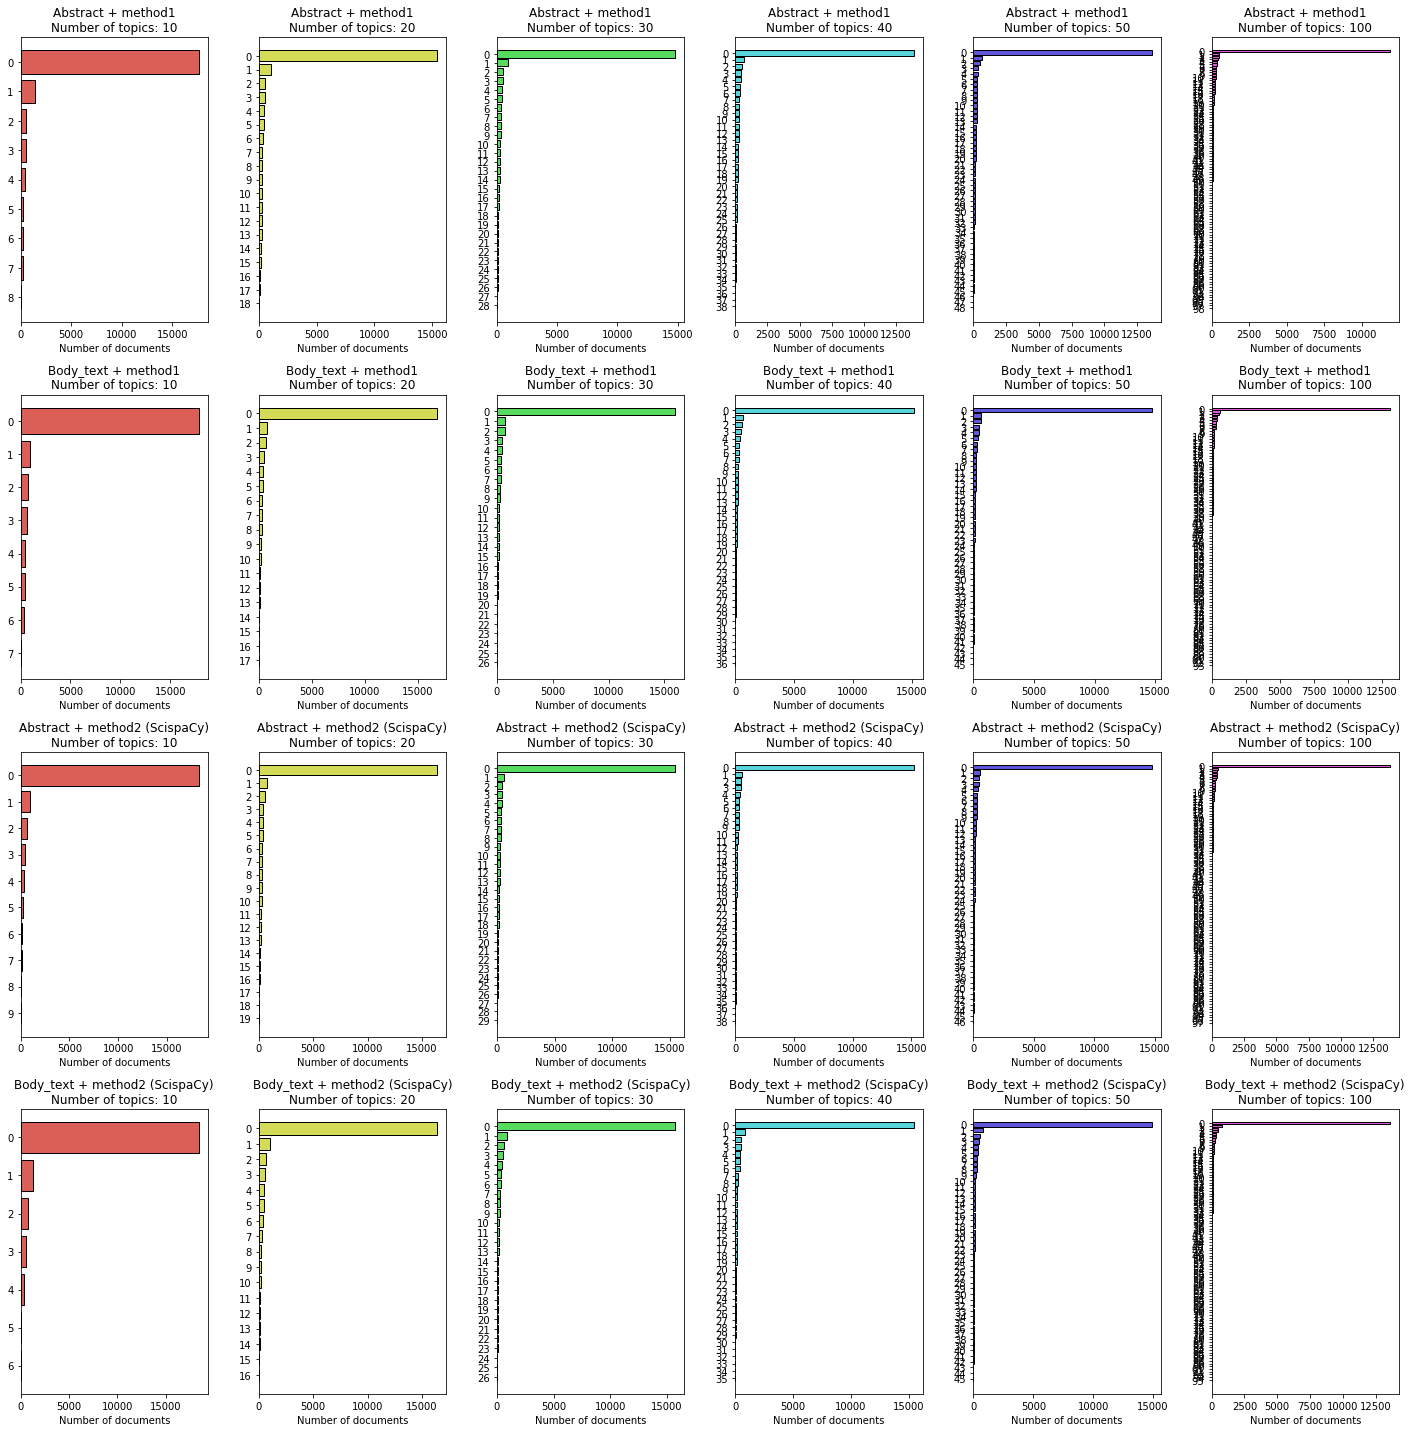

In [267]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file=files[i][j]
        axes[i][j].barh(np.arange(len(file)),file.pred,edgecolor="black",color=palette[j])
        axes[i][j].set_yticks(np.arange(len(file)))
        #axes[i][j].set_yticklabels(["Topic{}".format(i) for i in file.index])
        axes[i][j].invert_yaxis()
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
        axes[i][j].set_xlabel("Number of documents")
plt.tight_layout()

<a id='Part3.2_link'></a>
### 3.2 Evaluate the topic prediction performance of LSA models

In [268]:
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred2_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred3_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred4_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred5_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred6_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred7_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred8_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred9_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred10_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred11_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred12_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred13_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred14_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred15_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred16_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred17_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred18_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred19_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred20_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred21_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred22_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred23_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred24_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])

pred25_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred26_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred27_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred28_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred29_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred30_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred31_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred32_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred33_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred34_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred35_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred36_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred37_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred38_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred39_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred40_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred41_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred42_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred43_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred44_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred45_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred46_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred47_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])
pred48_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["rank","paper_id"])


In [269]:
files=[[pred1_df,pred3_df,pred5_df,pred7_df,pred9_df,pred11_df],
       [pred2_df,pred4_df,pred6_df,pred8_df,pred10_df,pred12_df],
       [pred13_df,pred15_df,pred17_df,pred19_df,pred21_df,pred23_df],
       [pred14_df,pred16_df,pred18_df,pred20_df,pred22_df,pred24_df],
       [pred25_df,pred27_df,pred29_df,pred31_df,pred33_df,pred35_df],
       [pred26_df,pred28_df,pred30_df,pred32_df,pred34_df,pred36_df],
       [pred37_df,pred39_df,pred41_df,pred43_df,pred45_df,pred47_df],
       [pred38_df,pred40_df,pred42_df,pred44_df,pred46_df,pred48_df]]
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract pred Title","Abstract pred Bodytext","Bodytext pred Title","Bodytext pred Abstract"]
norms=[10,20,30,40,50,100]
bws=[1/10,1/20,1/30,1/40,1/50,1/100]

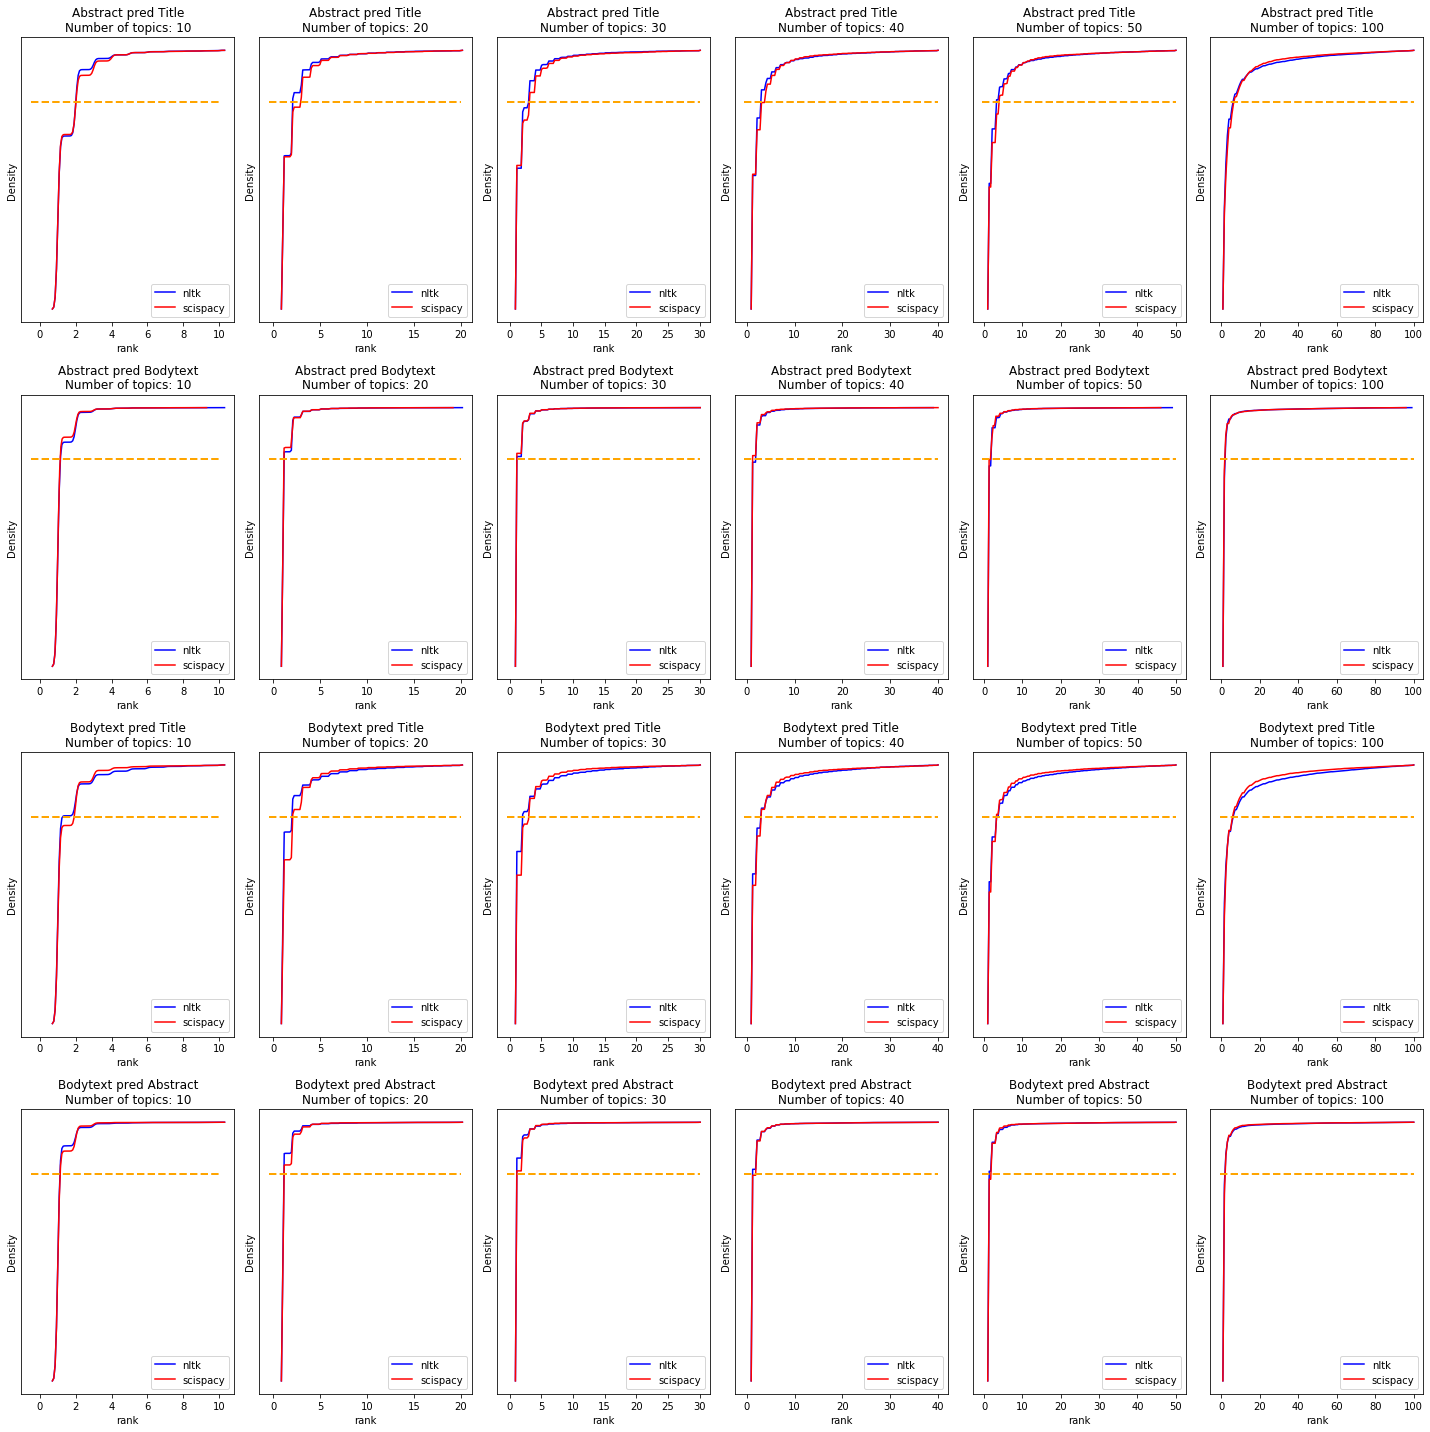

In [270]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.distplot(file1["rank"],ax=axes[i][j],hist=False,color="blue",label="nltk",hist_kws={"cumulative":True},kde_kws={"cumulative":True,"bw":bws[j]})
        sns.distplot(file2["rank"],ax=axes[i][j],hist=False,color="red",label="scispacy",hist_kws={"cumulative":True},kde_kws={"cumulative":True,"bw":bws[j]})
        axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

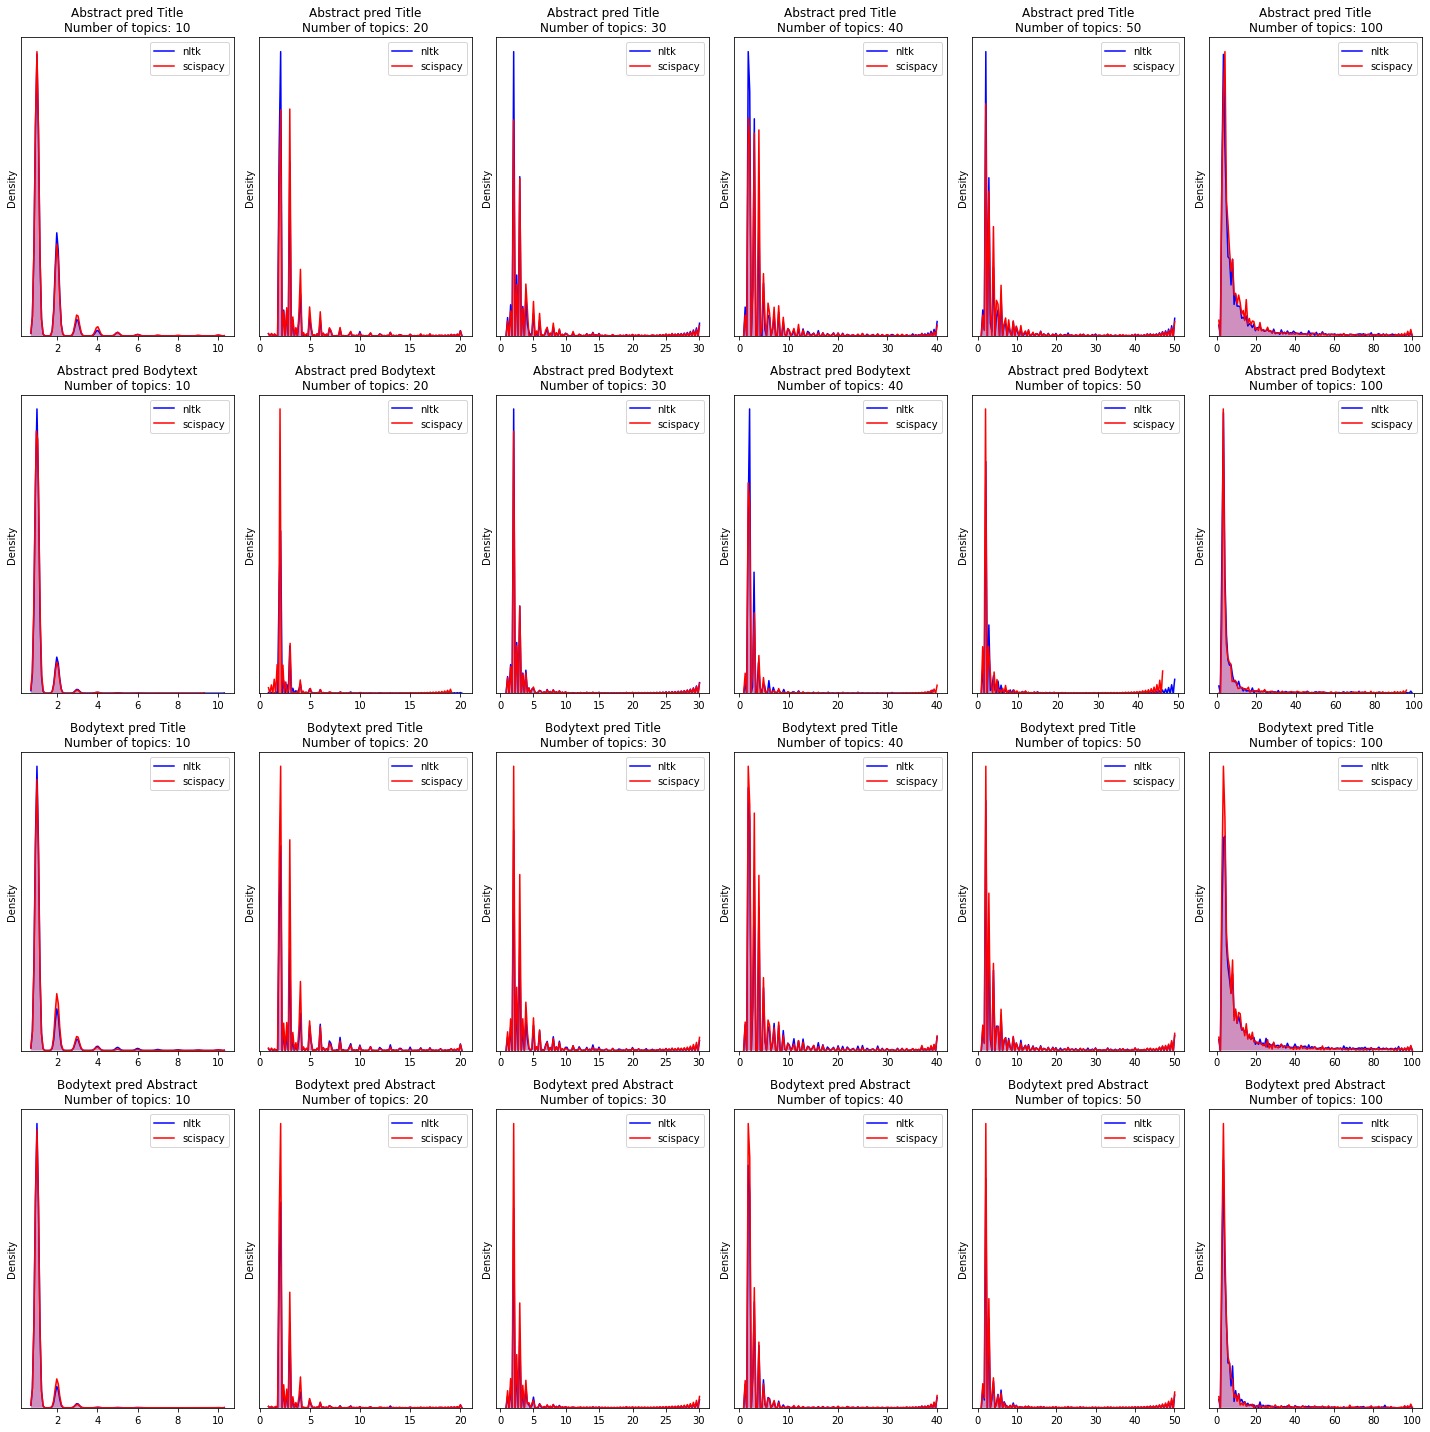

In [271]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.kdeplot(file1["rank"],ax=axes[i][j],shade=True,color="blue",label="nltk",bw=bws[j])
        sns.kdeplot(file2["rank"],ax=axes[i][j],shade=True,color="red",label="scispacy",bw=bws[j])
        #axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

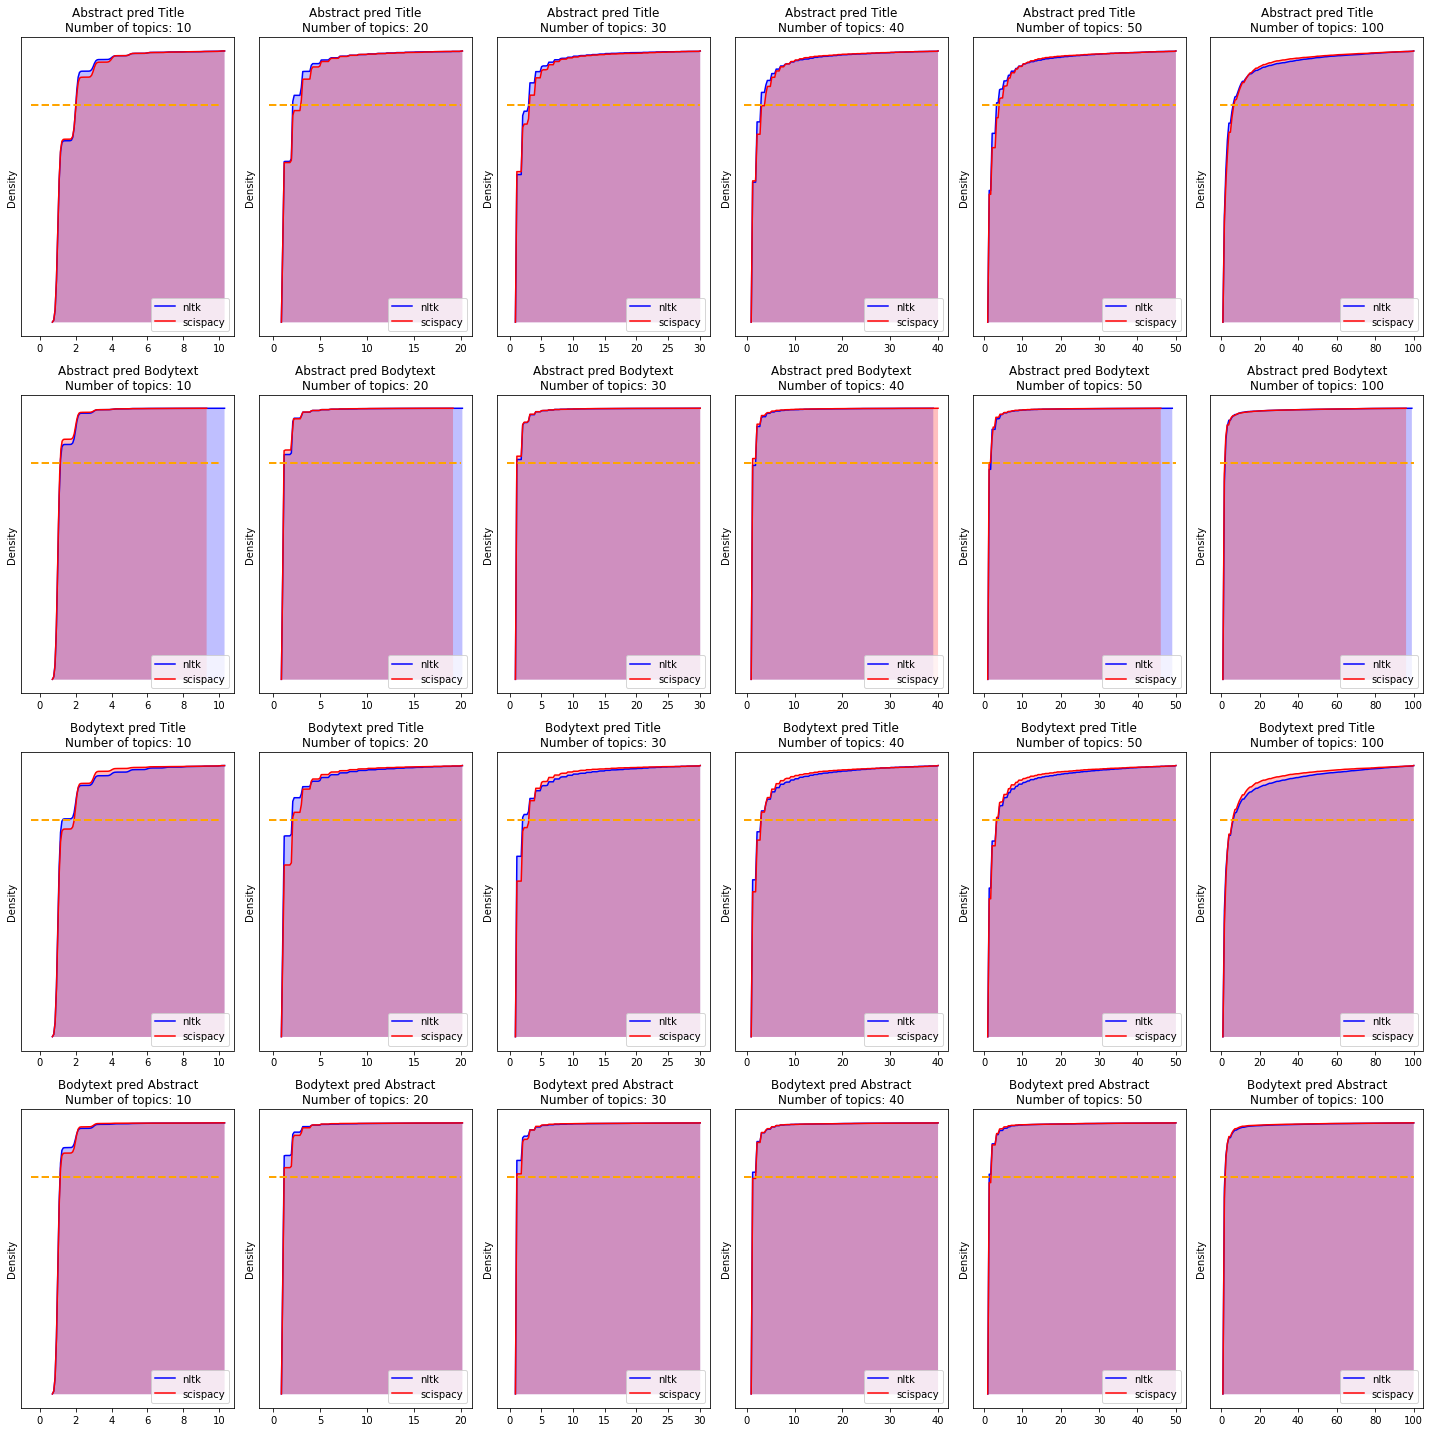

In [272]:
palette=sns.color_palette("hls",6)
fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(4):
    for j in range(6):
        file1=files[i][j]
        file2=files[i+4][j]
        sns.kdeplot(file1["rank"],ax=axes[i][j],shade=True,color="blue",label="nltk",bw=bws[j],cumulative=True)
        sns.kdeplot(file2["rank"],ax=axes[i][j],shade=True,color="red",label="scispacy",bw=bws[j],cumulative=True)
        axes[i][j].plot([-0.5,norms[j]],[0.8,0.8],"k--",color="orange",linewidth=2)
        axes[i][j].set_yticks([])
        axes[i][j].set_ylabel("Density")
        axes[i][j].set_title(filename_list2[i]+"\n"+filename_list1[j])
plt.tight_layout()

<a id='Part3.3_link'></a>
### 3.3 Compute cosine similarity for titles, abstracts and bodytext of each paper

In [ ]:
lsavector1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector10_df.csv"),index_col="paper_id")
lsavector2_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector20_df.csv"),index_col="paper_id")
lsavector3_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector30_df.csv"),index_col="paper_id")
lsavector4_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector40_df.csv"),index_col="paper_id")
lsavector5_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector50_df.csv"),index_col="paper_id")
lsavector6_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_lsavector100_df.csv"),index_col="paper_id")
lsavector7_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector10_df.csv"),index_col="paper_id")
lsavector8_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector20_df.csv"),index_col="paper_id")
lsavector9_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector30_df.csv"),index_col="paper_id")
lsavector10_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector40_df.csv"),index_col="paper_id")
lsavector11_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector50_df.csv"),index_col="paper_id")
lsavector12_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_lsavector100_df.csv"),index_col="paper_id")
lsavector13_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector10_df.csv"),index_col="paper_id")
lsavector14_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector20_df.csv"),index_col="paper_id")
lsavector15_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector30_df.csv"),index_col="paper_id")
lsavector16_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector40_df.csv"),index_col="paper_id")
lsavector17_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector50_df.csv"),index_col="paper_id")
lsavector18_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_lsavector100_df.csv"),index_col="paper_id")
lsavector19_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector10_df.csv"),index_col="paper_id")
lsavector20_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector20_df.csv"),index_col="paper_id")
lsavector21_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector30_df.csv"),index_col="paper_id")
lsavector22_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector40_df.csv"),index_col="paper_id")
lsavector23_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector50_df.csv"),index_col="paper_id")
lsavector24_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_lsavector100_df.csv"),index_col="paper_id")


In [4]:
pred1_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred2_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id")
pred3_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred4_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index_col="paper_id")
pred5_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred6_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id")
pred7_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred8_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id")
pred9_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred10_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id")
pred11_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred12_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id")
pred13_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id")
pred14_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id")
pred15_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id")
pred16_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id")
pred17_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id")
pred18_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id")
pred19_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id")
pred20_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id")
pred21_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id")
pred22_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id")
pred23_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id")
pred24_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id")

pred25_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred26_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id")
pred27_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred28_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id")
pred29_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred30_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id")
pred31_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred32_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id")
pred33_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred34_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id")
pred35_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred36_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id")
pred37_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id")
pred38_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id")
pred39_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id")
pred40_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id")
pred41_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id")
pred42_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id")
pred43_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id")
pred44_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id")
pred45_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id")
pred46_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id")
pred47_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id")
pred48_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id")


In [ ]:
def get_similarity_rank(ldavector_df,query,paper_id):
    if np.isnan(query.squeeze()[0]):
        return len(ldavector_df)
    cos_sim=cosine_similarity(X=ldavector_df,Y=query)
    cos_sim_df=pd.DataFrame({"paper_id":ldavector_df.index,"cosine_similarity":cos_sim.squeeze()}).sort_values(by=["cosine_similarity"],ascending=False).reset_index().drop(["index"],axis=1)
    return int(cos_sim_df[cos_sim_df.paper_id==paper_id].index.values)

In [ ]:
pred1_df["paper_id"]=pred1_df.index
pred1_df["cosine_similarity_rank"]=pred1_df.apply(lambda x:get_similarity_rank(lsavector1_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred1_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index=False)

In [ ]:
pred2_df["paper_id"]=pred2_df.index
pred2_df["cosine_similarity_rank"]=pred2_df.apply(lambda x:get_similarity_rank(lsavector1_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred2_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index=False)


In [ ]:
pred3_df["paper_id"]=pred3_df.index
pred3_df["cosine_similarity_rank"]=pred3_df.apply(lambda x:get_similarity_rank(lsavector2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred3_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index=False)

In [ ]:
pred4_df["paper_id"]=pred4_df.index
pred4_df["cosine_similarity_rank"]=pred4_df.apply(lambda x:get_similarity_rank(lsavector2_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred4_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index=False)

In [ ]:
pred5_df["paper_id"]=pred5_df.index
pred5_df["cosine_similarity_rank"]=pred5_df.apply(lambda x:get_similarity_rank(lsavector3_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred5_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred6_df["paper_id"]=pred6_df.index
pred6_df["cosine_similarity_rank"]=pred6_df.apply(lambda x:get_similarity_rank(lsavector3_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred6_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred7_df["paper_id"]=pred7_df.index
pred7_df["cosine_similarity_rank"]=pred7_df.apply(lambda x:get_similarity_rank(lsavector4_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred7_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred8_df["paper_id"]=pred8_df.index
pred8_df["cosine_similarity_rank"]=pred8_df.apply(lambda x:get_similarity_rank(lsavector4_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred8_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred9_df["paper_id"]=pred9_df.index
pred9_df["cosine_similarity_rank"]=pred9_df.apply(lambda x:get_similarity_rank(lsavector5_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred9_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred10_df["paper_id"]=pred10_df.index
pred10_df["cosine_similarity_rank"]=pred10_df.apply(lambda x:get_similarity_rank(lsavector5_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred10_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred11_df["paper_id"]=pred11_df.index
pred11_df["cosine_similarity_rank"]=pred11_df.apply(lambda x:get_similarity_rank(lsavector6_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred11_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred12_df["paper_id"]=pred12_df.index
pred12_df["cosine_similarity_rank"]=pred12_df.apply(lambda x:get_similarity_rank(lsavector6_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred12_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred13_df["paper_id"]=pred13_df.index
pred13_df["cosine_similarity_rank"]=pred13_df.apply(lambda x:get_similarity_rank(lsavector7_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred13_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index=False)


In [ ]:
pred14_df["paper_id"]=pred14_df.index
pred14_df["cosine_similarity_rank"]=pred14_df.apply(lambda x:get_similarity_rank(lsavector7_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred14_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index=False)


In [ ]:
pred15_df["paper_id"]=pred15_df.index
pred15_df["cosine_similarity_rank"]=pred15_df.apply(lambda x:get_similarity_rank(lsavector8_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred15_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index=False)


In [ ]:
pred16_df["paper_id"]=pred16_df.index
pred16_df["cosine_similarity_rank"]=pred16_df.apply(lambda x:get_similarity_rank(lsavector8_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred16_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index=False)


In [ ]:
pred17_df["paper_id"]=pred17_df.index
pred17_df["cosine_similarity_rank"]=pred17_df.apply(lambda x:get_similarity_rank(lsavector9_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred17_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred18_df["paper_id"]=pred18_df.index
pred18_df["cosine_similarity_rank"]=pred18_df.apply(lambda x:get_similarity_rank(lsavector9_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred18_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index=False)


In [ ]:
pred19_df["paper_id"]=pred19_df.index
pred19_df["cosine_similarity_rank"]=pred19_df.apply(lambda x:get_similarity_rank(lsavector10_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred19_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred20_df["paper_id"]=pred20_df.index
pred20_df["cosine_similarity_rank"]=pred20_df.apply(lambda x:get_similarity_rank(lsavector10_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred20_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index=False)


In [ ]:
pred21_df["paper_id"]=pred21_df.index
pred21_df["cosine_similarity_rank"]=pred21_df.apply(lambda x:get_similarity_rank(lsavector11_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred21_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred22_df["paper_id"]=pred22_df.index
pred22_df["cosine_similarity_rank"]=pred22_df.apply(lambda x:get_similarity_rank(lsavector11_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred22_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index=False)


In [ ]:
pred23_df["paper_id"]=pred23_df.index
pred23_df["cosine_similarity_rank"]=pred23_df.apply(lambda x:get_similarity_rank(lsavector12_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred23_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred24_df["paper_id"]=pred24_df.index
pred24_df["cosine_similarity_rank"]=pred24_df.apply(lambda x:get_similarity_rank(lsavector12_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred24_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index=False)


In [ ]:
pred25_df["paper_id"]=pred25_df.index
pred25_df["cosine_similarity_rank"]=pred25_df.apply(lambda x:get_similarity_rank(lsavector13_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred25_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred26_df["paper_id"]=pred26_df.index
pred26_df["cosine_similarity_rank"]=pred26_df.apply(lambda x:get_similarity_rank(lsavector13_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred26_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred27_df["paper_id"]=pred27_df.index
pred27_df["cosine_similarity_rank"]=pred27_df.apply(lambda x:get_similarity_rank(lsavector14_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred27_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred28_df["paper_id"]=pred28_df.index
pred28_df["cosine_similarity_rank"]=pred28_df.apply(lambda x:get_similarity_rank(lsavector14_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred28_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred29_df["paper_id"]=pred29_df.index
pred29_df["cosine_similarity_rank"]=pred29_df.apply(lambda x:get_similarity_rank(lsavector15_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred29_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred30_df["paper_id"]=pred30_df.index
pred30_df["cosine_similarity_rank"]=pred30_df.apply(lambda x:get_similarity_rank(lsavector15_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred30_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred31_df["paper_id"]=pred31_df.index
pred31_df["cosine_similarity_rank"]=pred31_df.apply(lambda x:get_similarity_rank(lsavector16_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred31_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred32_df["paper_id"]=pred32_df.index
pred32_df["cosine_similarity_rank"]=pred32_df.apply(lambda x:get_similarity_rank(lsavector16_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred32_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred33_df["paper_id"]=pred33_df.index
pred33_df["cosine_similarity_rank"]=pred33_df.apply(lambda x:get_similarity_rank(lsavector17_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred33_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred34_df["paper_id"]=pred34_df.index
pred34_df["cosine_similarity_rank"]=pred34_df.apply(lambda x:get_similarity_rank(lsavector17_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred34_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred35_df["paper_id"]=pred35_df.index
pred35_df["cosine_similarity_rank"]=pred35_df.apply(lambda x:get_similarity_rank(lsavector18_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred35_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index=False)


In [ ]:
pred36_df["paper_id"]=pred36_df.index
pred36_df["cosine_similarity_rank"]=pred36_df.apply(lambda x:get_similarity_rank(lsavector18_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred36_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index=False)


In [ ]:
pred37_df["paper_id"]=pred37_df.index
pred37_df["cosine_similarity_rank"]=pred37_df.apply(lambda x:get_similarity_rank(lsavector19_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred37_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred38_df["paper_id"]=pred38_df.index
pred38_df["cosine_similarity_rank"]=pred38_df.apply(lambda x:get_similarity_rank(lsavector19_df.iloc[:,:10],np.reshape(x.values[:10],(1,-1)),x.paper_id),axis=1)
pred38_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index=False)


In [ ]:
pred39_df["paper_id"]=pred39_df.index
pred39_df["cosine_similarity_rank"]=pred39_df.apply(lambda x:get_similarity_rank(lsavector20_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred39_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred40_df["paper_id"]=pred40_df.index
pred40_df["cosine_similarity_rank"]=pred40_df.apply(lambda x:get_similarity_rank(lsavector20_df.iloc[:,:20],np.reshape(x.values[:20],(1,-1)),x.paper_id),axis=1)
pred40_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index=False)


In [ ]:
pred41_df["paper_id"]=pred41_df.index
pred41_df["cosine_similarity_rank"]=pred41_df.apply(lambda x:get_similarity_rank(lsavector21_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred41_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred42_df["paper_id"]=pred42_df.index
pred42_df["cosine_similarity_rank"]=pred42_df.apply(lambda x:get_similarity_rank(lsavector21_df.iloc[:,:30],np.reshape(x.values[:30],(1,-1)),x.paper_id),axis=1)
pred42_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index=False)


In [ ]:
pred43_df["paper_id"]=pred43_df.index
pred43_df["cosine_similarity_rank"]=pred43_df.apply(lambda x:get_similarity_rank(lsavector22_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred43_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred44_df["paper_id"]=pred44_df.index
pred44_df["cosine_similarity_rank"]=pred44_df.apply(lambda x:get_similarity_rank(lsavector22_df.iloc[:,:40],np.reshape(x.values[:40],(1,-1)),x.paper_id),axis=1)
pred44_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index=False)


In [ ]:
pred45_df["paper_id"]=pred45_df.index
pred45_df["cosine_similarity_rank"]=pred45_df.apply(lambda x:get_similarity_rank(lsavector23_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred45_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred46_df["paper_id"]=pred46_df.index
pred46_df["cosine_similarity_rank"]=pred46_df.apply(lambda x:get_similarity_rank(lsavector23_df.iloc[:,:50],np.reshape(x.values[:50],(1,-1)),x.paper_id),axis=1)
pred46_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index=False)


In [ ]:
pred47_df["paper_id"]=pred47_df.index
pred47_df["cosine_similarity_rank"]=pred47_df.apply(lambda x:get_similarity_rank(lsavector24_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred47_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index=False)


In [ ]:
pred48_df["paper_id"]=pred48_df.index
pred48_df["cosine_similarity_rank"]=pred48_df.apply(lambda x:get_similarity_rank(lsavector24_df.iloc[:,:100],np.reshape(x.values[:100],(1,-1)),x.paper_id),axis=1)
pred48_df.to_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index=False)


<a id='Part3.4_link'></a>
### 3.4 Evaluate cosine similarity

In [9]:
pred_files=[pred1_df,pred3_df,pred5_df,pred7_df,pred9_df,pred11_df,pred2_df,pred4_df,pred6_df,pred8_df,pred10_df,pred12_df,
            pred13_df,pred15_df,pred17_df,pred19_df,pred21_df,pred23_df,pred14_df,pred16_df,pred18_df,pred20_df,pred22_df,pred24_df,
            pred25_df,pred27_df,pred29_df,pred31_df,pred33_df,pred35_df,pred26_df,pred28_df,pred30_df,pred32_df,pred34_df,pred36_df,
            pred37_df,pred39_df,pred41_df,pred43_df,pred45_df,pred47_df,pred38_df,pred40_df,pred42_df,pred44_df,pred46_df,pred48_df]


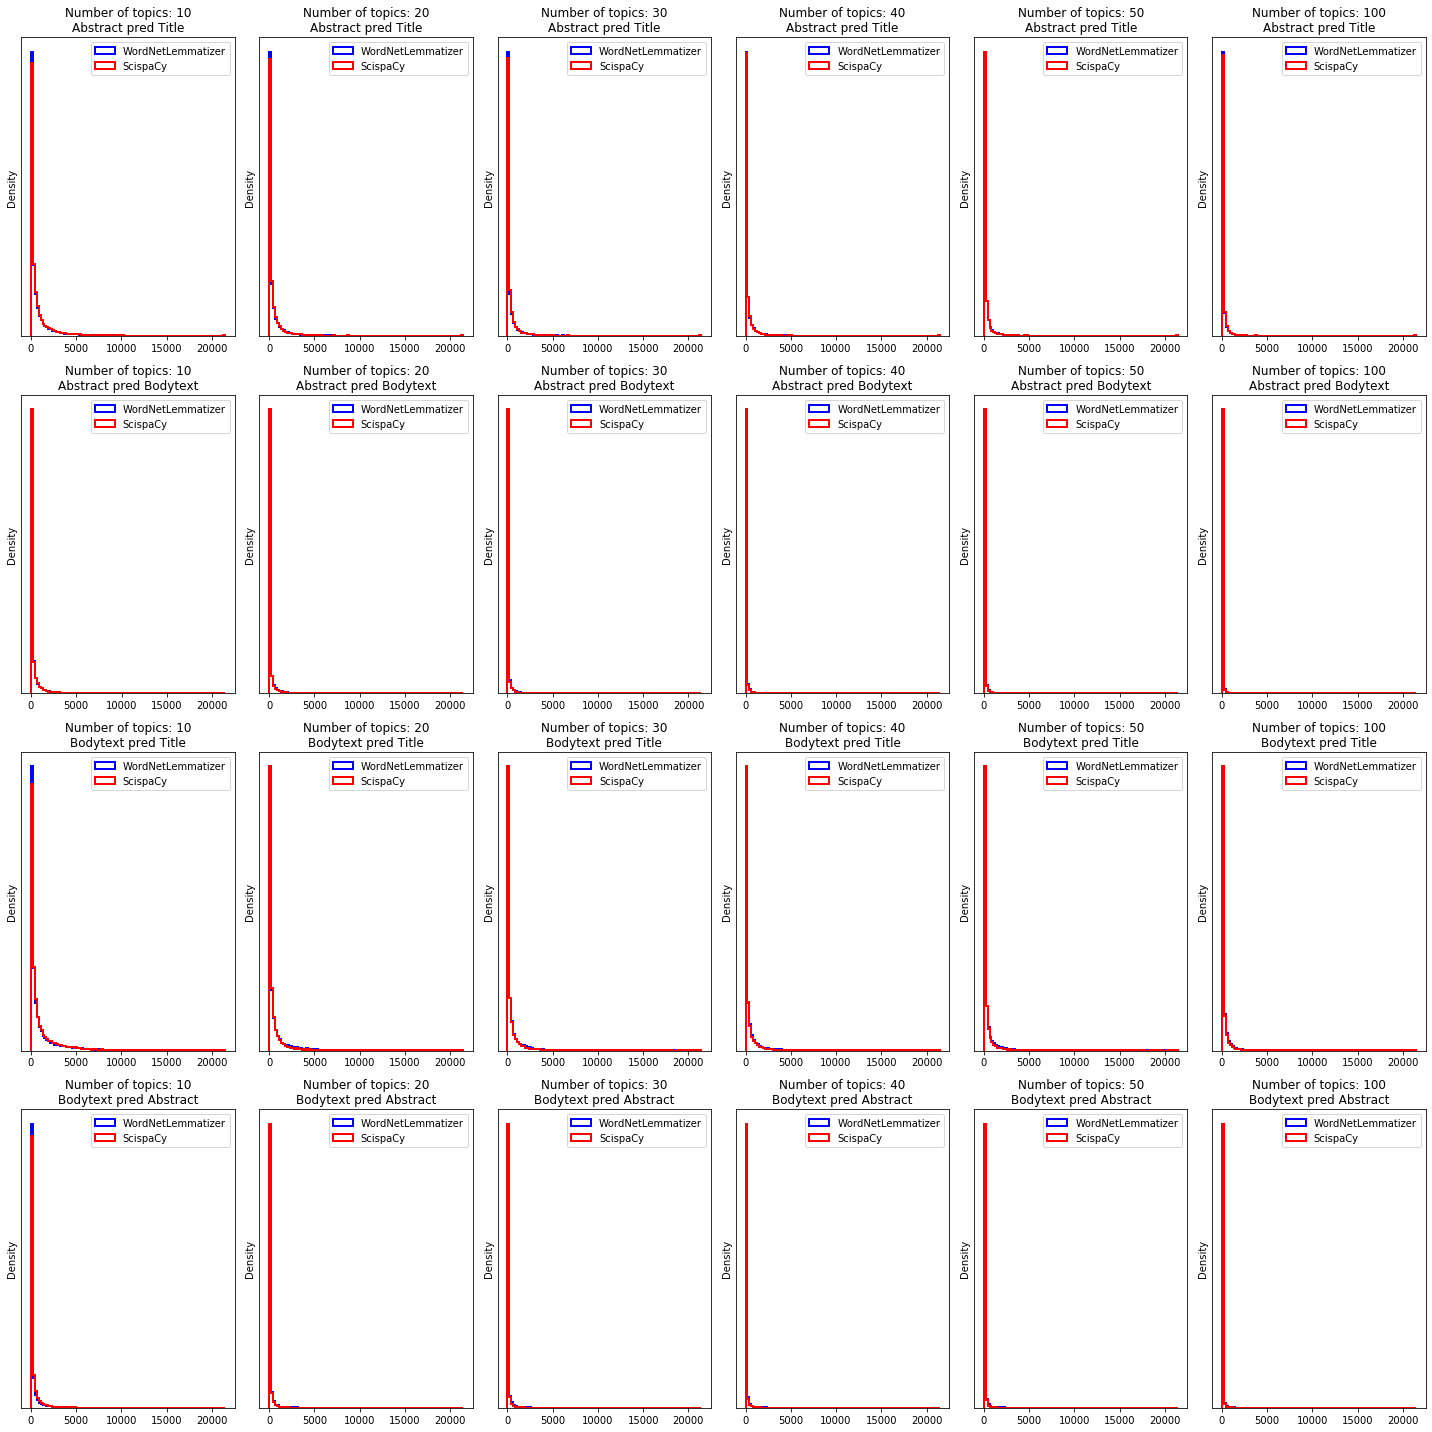

In [11]:
## compare WordNetLemmatizer and scispacy
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list2=["Abstract pred Title","Abstract pred Bodytext","Bodytext pred Title","Bodytext pred Abstract"]

fig,axes=plt.subplots(4,6,figsize=(20,20))
for i in range(24):
    file1=pred_files[i]
    file2=pred_files[i+24]
    axes[i//6][i%6].hist(file1["cosine_similarity_rank"],bins=100,histtype="step",color="blue",label="WordNetLemmatizer",linewidth=2)
    axes[i//6][i%6].hist(file2["cosine_similarity_rank"],bins=100,histtype="step",color="red",label="ScispaCy",linewidth=2)
    axes[i//6][i%6].set_yticks([])
    axes[i//6][i%6].set_ylabel("Density")
    axes[i//6][i%6].set_title(filename_list1[i%6]+"\n"+filename_list2[i//6])
    axes[i//6][i%6].legend()
plt.tight_layout()

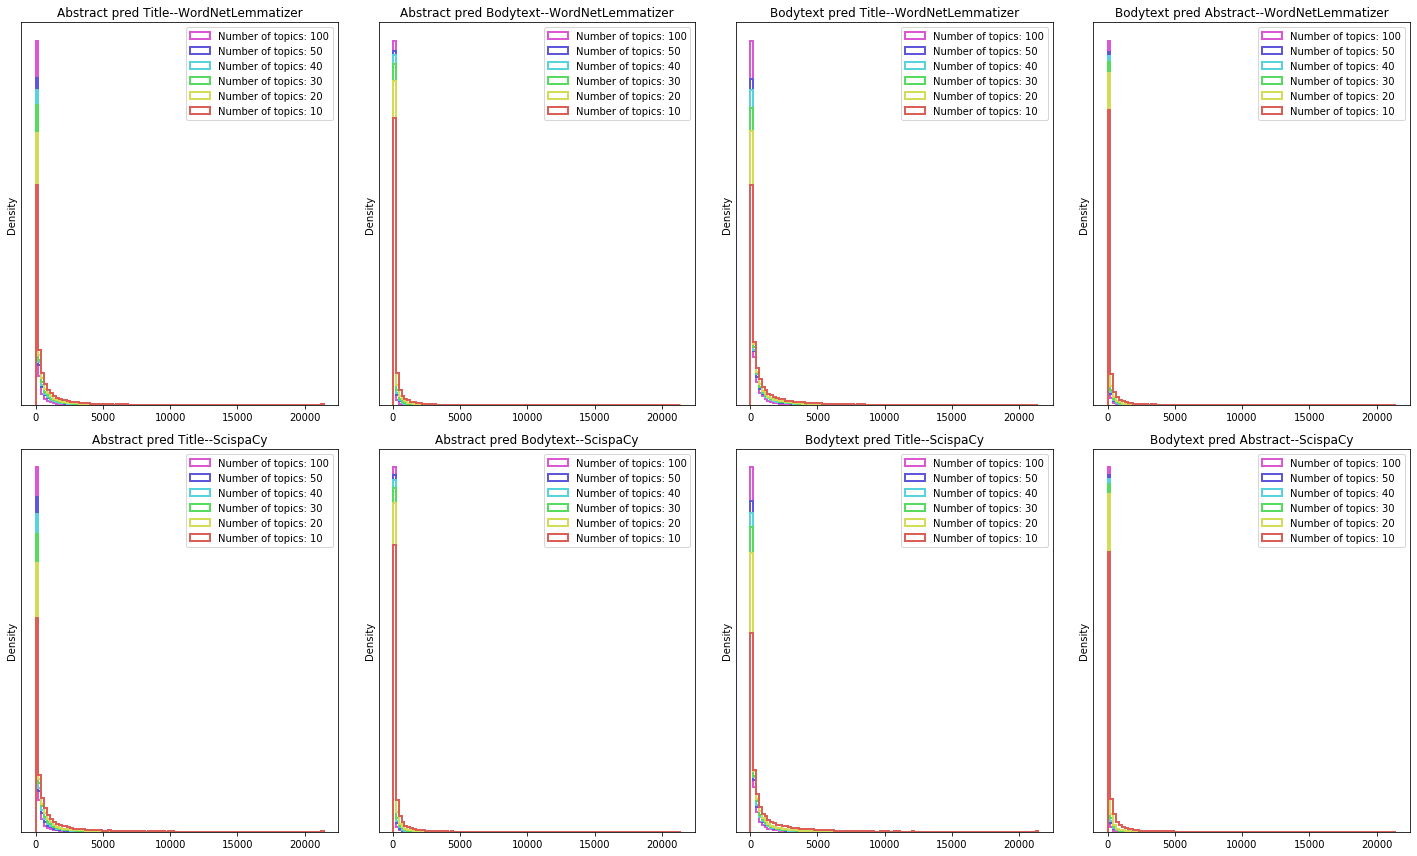

In [15]:
filename_list3=["Abstract pred Title--WordNetLemmatizer","Abstract pred Bodytext--WordNetLemmatizer","Bodytext pred Title--WordNetLemmatizer","Bodytext pred Abstract--WordNetLemmatizer",
                "Abstract pred Title--ScispaCy","Abstract pred Bodytext--ScispaCy","Bodytext pred Title--ScispaCy","Bodytext pred Abstract--ScispaCy"]
palette=sns.color_palette("hls",6)

fig,axes=plt.subplots(2,4,figsize=(20,12))
for i in range(7,-1,-1):
    for j in range(5,-1,-1):
        file=pred_files[i*6+j]
        axes[i//4][i%4].hist(file["cosine_similarity_rank"],bins=100,histtype="step",color=palette[j],label=filename_list1[j],linewidth=2)
    axes[i//4][i%4].set_yticks([])
    axes[i//4][i%4].set_ylabel("Density")
    axes[i//4][i%4].set_title(filename_list3[i])
    axes[i//4][i%4].legend()
plt.tight_layout()

## Conclusion
<br> 1. **WordNetLemmatizer** and **ScispaCy** have comparable performance in preprocessing text
<br> 2. In general, increased number of topics in LSA analysis has better embedding performance based on the cosine similarity score rank among abstracts/titles/bodytext for each paper
<br> 3. LSA models built on abstract and bodytext can predict topics for bodytext/title and abstract/title with good performance.